In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 109.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.12.0.88
    Uninstalling open

1. pull up

Saving pull up_13.mp4 to pull up_13 (3).mp4
Video uploaded as: pull up_13 (3).mp4
Video dimensions: width=1280, height=720
Done! Data saved to velocity_pushup_updated.xlsx


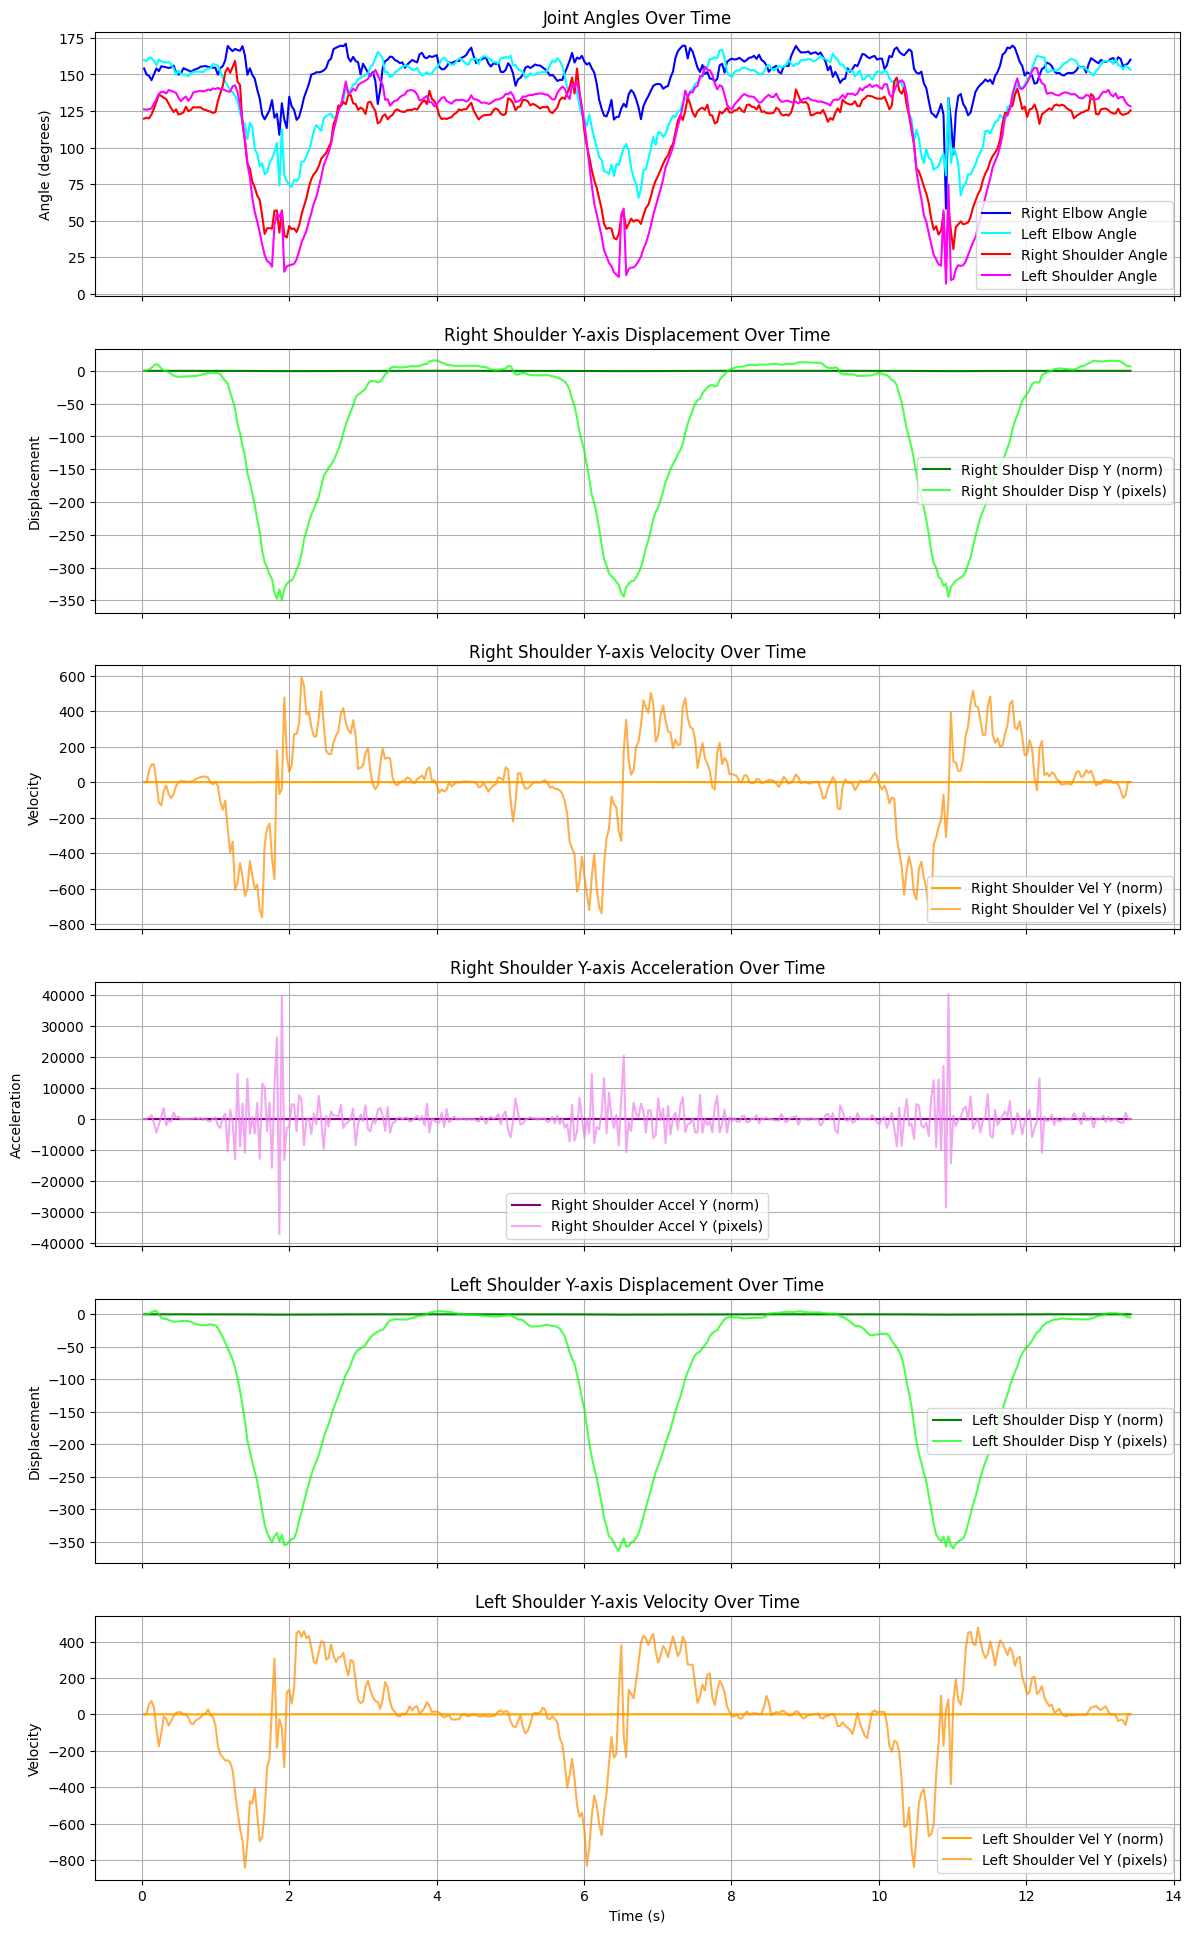

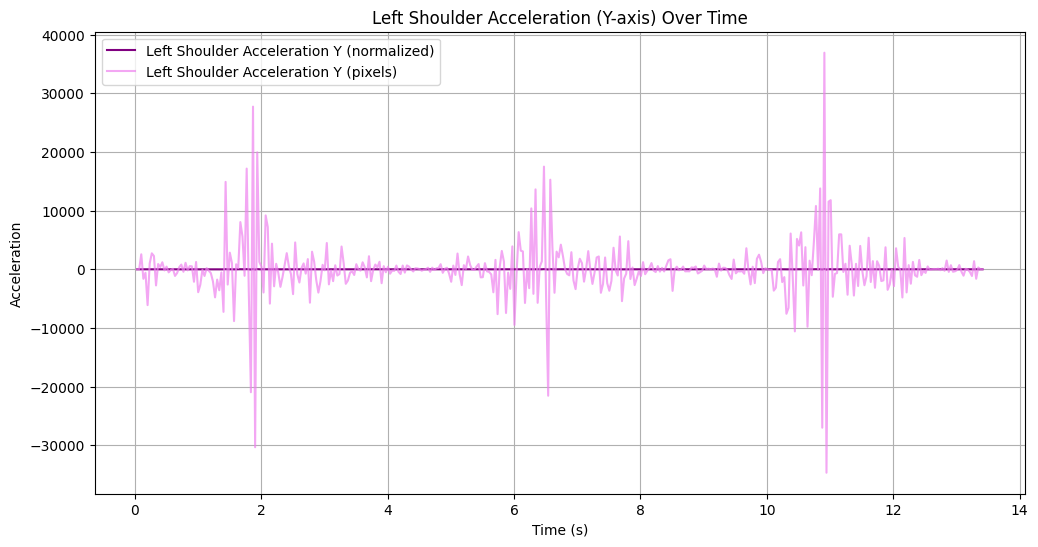

<Figure size 640x480 with 0 Axes>

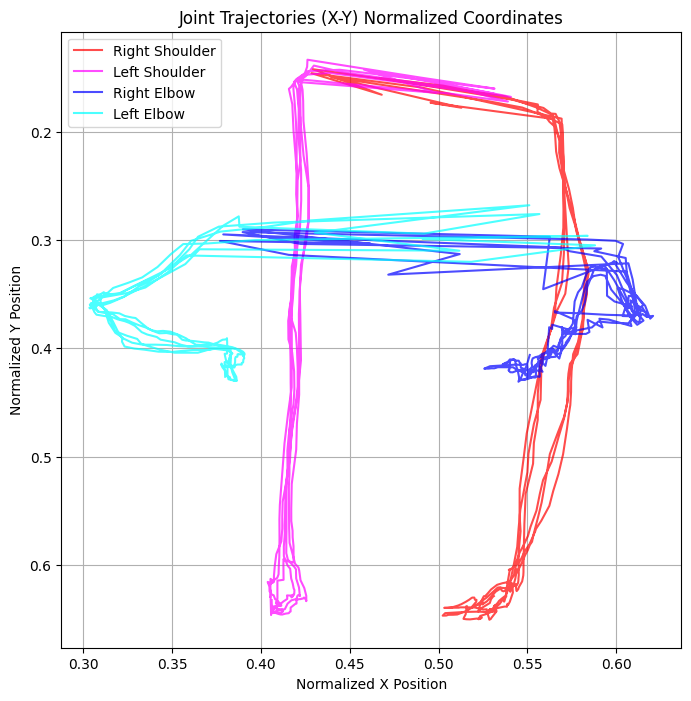

In [ ]:
# Required imports
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Upload video file in Google Colab environment
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]
print("Video uploaded as:", VIDEO_PATH)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Angle calculation function using three 3D points
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

data = []
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_num = 0

frame_width = None
frame_height = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1

    if frame_num == 1:
        frame_height, frame_width = frame.shape[:2]
        print(f"Video dimensions: width={frame_width}, height={frame_height}")

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        row = [frame_num]

        for lm in landmarks:
            row.extend([lm.x, lm.y, lm.z])

        # Calculate right elbow angle (shoulder=12, elbow=14, wrist=16)
        a = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        b = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        c = [landmarks[16].x, landmarks[16].y, landmarks[16].z]
        right_elbow_angle = calculate_angle(a, b, c)

        # Calculate left elbow angle (shoulder=11, elbow=13, wrist=15)
        a_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        b_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        c_l = [landmarks[15].x, landmarks[15].y, landmarks[15].z]
        left_elbow_angle = calculate_angle(a_l, b_l, c_l)

        # Calculate right shoulder angle (hip=24, shoulder=12, elbow=14)
        a_sh = [landmarks[24].x, landmarks[24].y, landmarks[24].z]
        b_sh = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        c_sh = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        right_shoulder_angle = calculate_angle(a_sh, b_sh, c_sh)

        # Calculate left shoulder angle (hip=23, shoulder=11, elbow=13)
        a_sh_l = [landmarks[23].x, landmarks[23].y, landmarks[23].z]
        b_sh_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        c_sh_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        left_shoulder_angle = calculate_angle(a_sh_l, b_sh_l, c_sh_l)

        # Append angles to row
        row.extend([right_elbow_angle, left_elbow_angle, right_shoulder_angle, left_shoulder_angle])

        data.append(row)

cap.release()
pose.close()

# Create DataFrame
columns = ['frame']
for i in range(33):
    columns += [f'lm{i}_x', f'lm{i}_y', f'lm{i}_z']
columns += ['right_elbow_angle_deg', 'left_elbow_angle_deg', 'right_shoulder_angle_deg', 'left_shoulder_angle_deg']
df = pd.DataFrame(data, columns=columns)

# Convert landmarks to float
df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']] = df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']].astype(float)

# Calculate pixel coordinates for shoulder landmarks (right and left)
df['lm12_x_px'] = df['lm12_x'] * frame_width
df['lm12_y_px'] = df['lm12_y'] * frame_height
df['lm11_x_px'] = df['lm11_x'] * frame_width
df['lm11_y_px'] = df['lm11_y'] * frame_height

# Calculate displacement, velocity and acceleration for right shoulder y (normalized and in pixels)
df['shoulder_disp_y'] = df['lm12_y'].diff().fillna(0)
df['shoulder_disp_y_px'] = df['lm12_y_px'].diff().fillna(0)

h = 1.0 / fps

# Velocity (5-point central difference) y-axis normalized and pixel
df['shoulder_vy'] = (-df['lm12_y'].shift(-2) + 8*df['lm12_y'].shift(-1) - 8*df['lm12_y'].shift(1) + df['lm12_y'].shift(2)) / (12 * h)
df['shoulder_vy_px'] = (-df['lm12_y_px'].shift(-2) + 8*df['lm12_y_px'].shift(-1) - 8*df['lm12_y_px'].shift(1) + df['lm12_y_px'].shift(2)) / (12 * h)

# Acceleration (5-point central difference) y-axis normalized and pixel
df['shoulder_ay'] = (-df['lm12_y'].shift(-2) + 16*df['lm12_y'].shift(-1) - 30*df['lm12_y'] + 16*df['lm12_y'].shift(1) - df['lm12_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_px'] = (-df['lm12_y_px'].shift(-2) + 16*df['lm12_y_px'].shift(-1) - 30*df['lm12_y_px'] + 16*df['lm12_y_px'].shift(1) - df['lm12_y_px'].shift(2)) / (12 * h**2)

# Similarly for left shoulder y displacement etc. if needed (optional)
df['shoulder_disp_y_left'] = df['lm11_y'].diff().fillna(0)
df['shoulder_disp_y_left_px'] = df['lm11_y_px'].diff().fillna(0)
df['shoulder_vy_left'] = (-df['lm11_y'].shift(-2) + 8*df['lm11_y'].shift(-1) - 8*df['lm11_y'].shift(1) + df['lm11_y'].shift(2)) / (12 * h)
df['shoulder_vy_left_px'] = (-df['lm11_y_px'].shift(-2) + 8*df['lm11_y_px'].shift(-1) - 8*df['lm11_y_px'].shift(1) + df['lm11_y_px'].shift(2)) / (12 * h)
df['shoulder_ay_left'] = (-df['lm11_y'].shift(-2) + 16*df['lm11_y'].shift(-1) - 30*df['lm11_y'] + 16*df['lm11_y'].shift(1) - df['lm11_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_left_px'] = (-df['lm11_y_px'].shift(-2) + 16*df['lm11_y_px'].shift(-1) - 30*df['lm11_y_px'] + 16*df['lm11_y_px'].shift(1) - df['lm11_y_px'].shift(2)) / (12 * h**2)

# Calculate time vector
df['time_s'] = df['frame'] / fps
df.fillna(0, inplace=True)

# Save to Excel
df.to_excel('velocity_pushup_updated.xlsx', index=False)
print("Done! Data saved to velocity_pushup_updated.xlsx")

# --- Plotting ---

# Plot angles for elbows and shoulders both sides, displacement, velocity, acceleration for right shoulder
fig, axs = plt.subplots(6, 1, figsize=(14, 24), sharex=True)

# 1. Angles (Right and Left Elbow, Shoulder)
axs[0].plot(df['time_s'], df['right_elbow_angle_deg'], label='Right Elbow Angle', color='blue')
axs[0].plot(df['time_s'], df['left_elbow_angle_deg'], label='Left Elbow Angle', color='cyan')
axs[0].plot(df['time_s'], df['right_shoulder_angle_deg'], label='Right Shoulder Angle', color='red')
axs[0].plot(df['time_s'], df['left_shoulder_angle_deg'], label='Left Shoulder Angle', color='magenta')
axs[0].set_ylabel('Angle (degrees)')
axs[0].set_title('Joint Angles Over Time')
axs[0].legend()
axs[0].grid()

# 2. Right Shoulder Y Displacement (normalized and pixels)
axs[1].plot(df['time_s'], df['shoulder_disp_y'].cumsum(), label='Right Shoulder Disp Y (norm)', color='green')
axs[1].plot(df['time_s'], df['shoulder_disp_y_px'].cumsum(), label='Right Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[1].set_ylabel('Displacement')
axs[1].set_title('Right Shoulder Y-axis Displacement Over Time')
axs[1].legend()
axs[1].grid()

# 3. Right Shoulder Y Velocity (normalized and pixels)
axs[2].plot(df['time_s'], df['shoulder_vy'], label='Right Shoulder Vel Y (norm)', color='orange')
axs[2].plot(df['time_s'], df['shoulder_vy_px'], label='Right Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[2].set_ylabel('Velocity')
axs[2].set_title('Right Shoulder Y-axis Velocity Over Time')
axs[2].legend()
axs[2].grid()

# 4. Right Shoulder Y Acceleration (normalized and pixels)
axs[3].plot(df['time_s'], df['shoulder_ay'], label='Right Shoulder Accel Y (norm)', color='purple')
axs[3].plot(df['time_s'], df['shoulder_ay_px'], label='Right Shoulder Accel Y (pixels)', color='violet', alpha=0.7)
axs[3].set_ylabel('Acceleration')
axs[3].set_title('Right Shoulder Y-axis Acceleration Over Time')
axs[3].legend()
axs[3].grid()

# 5. Left Shoulder Y Displacement (normalized and pixels)
axs[4].plot(df['time_s'], df['shoulder_disp_y_left'].cumsum(), label='Left Shoulder Disp Y (norm)', color='green')
axs[4].plot(df['time_s'], df['shoulder_disp_y_left_px'].cumsum(), label='Left Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[4].set_ylabel('Displacement')
axs[4].set_title('Left Shoulder Y-axis Displacement Over Time')
axs[4].legend()
axs[4].grid()

# 6. Left Shoulder Y Velocity (normalized and pixels)
axs[5].plot(df['time_s'], df['shoulder_vy_left'], label='Left Shoulder Vel Y (norm)', color='orange')
axs[5].plot(df['time_s'], df['shoulder_vy_left_px'], label='Left Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[5].set_xlabel('Time (s)')
axs[5].set_ylabel('Velocity')
axs[5].set_title('Left Shoulder Y-axis Velocity Over Time')
axs[5].legend()
axs[5].grid()

plt.figure(figsize=(12, 6))
plt.plot(df['time_s'], df['shoulder_ay_left'], label='Left Shoulder Acceleration Y (normalized)', color='purple')
plt.plot(df['time_s'], df['shoulder_ay_left_px'], label='Left Shoulder Acceleration Y (pixels)', color='violet', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration')
plt.title('Left Shoulder Acceleration (Y-axis) Over Time')
plt.legend()
plt.grid()
plt.show()

plt.tight_layout()
plt.show()

# --- Plot x-y Trajectory for shoulders and elbows (normalized) ---

plt.figure(figsize=(8,8))
plt.plot(df['lm12_x'], df['lm12_y'], label='Right Shoulder', color='red', alpha=0.7)
plt.plot(df['lm11_x'], df['lm11_y'], label='Left Shoulder', color='magenta', alpha=0.7)
plt.plot(df['lm14_x'], df['lm14_y'], label='Right Elbow', color='blue', alpha=0.7)
plt.plot(df['lm13_x'], df['lm13_y'], label='Left Elbow', color='cyan', alpha=0.7)
plt.gca().invert_yaxis()  # Optional: invert y-axis if you want top of image as top
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.title('Joint Trajectories (X-Y) Normalized Coordinates')
plt.legend()
plt.grid()
plt.show()

import matplotlib.pyplot as plt




2. push up

Saving push-up_1.mp4 to push-up_1.mp4
Video uploaded as: push-up_1.mp4
Video dimensions: width=1920, height=1080
Done! Data saved to velocity_pushup_updated.xlsx


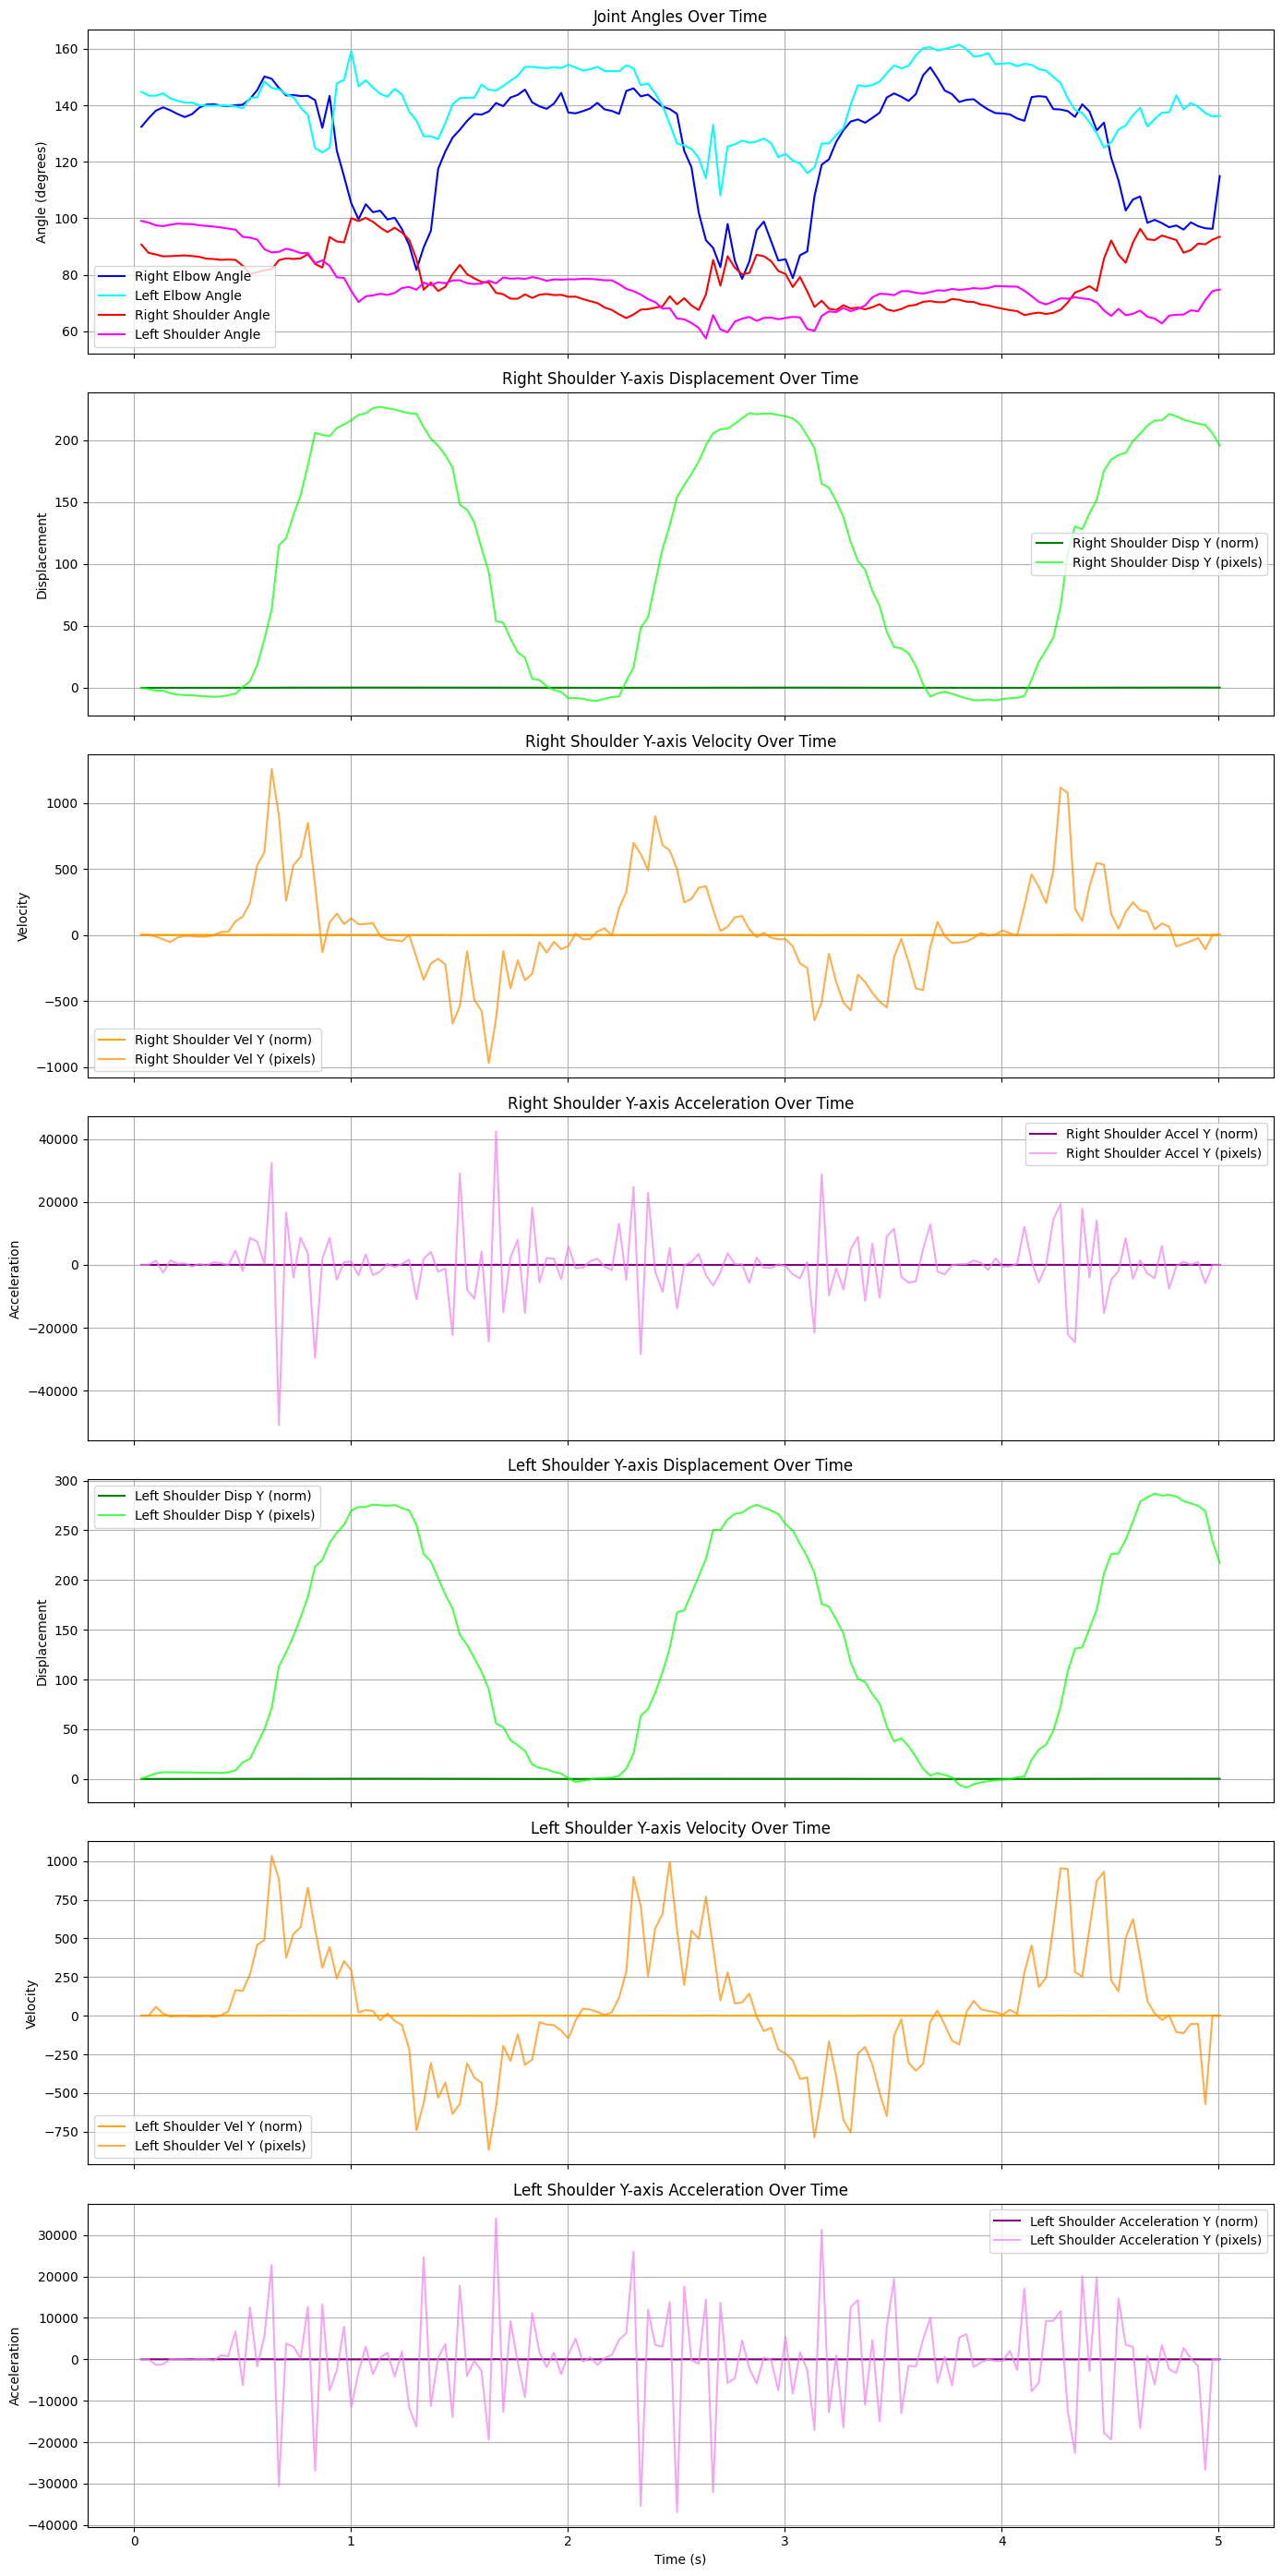

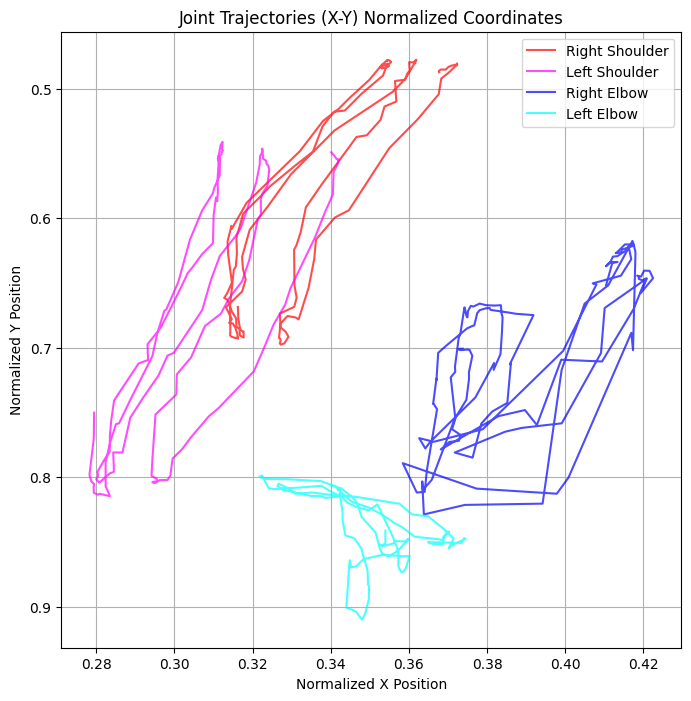

In [ ]:
# Required imports
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Upload video file in Google Colab environment
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]
print("Video uploaded as:", VIDEO_PATH)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Angle calculation function using three 3D points
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

data = []
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_num = 0

frame_width = None
frame_height = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1

    if frame_num == 1:
        frame_height, frame_width = frame.shape[:2]
        print(f"Video dimensions: width={frame_width}, height={frame_height}")

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        row = [frame_num]

        for lm in landmarks:
            row.extend([lm.x, lm.y, lm.z])

        # Calculate right elbow angle (shoulder=12, elbow=14, wrist=16)
        a = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        b = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        c = [landmarks[16].x, landmarks[16].y, landmarks[16].z]
        right_elbow_angle = calculate_angle(a, b, c)

        # Calculate left elbow angle (shoulder=11, elbow=13, wrist=15)
        a_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        b_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        c_l = [landmarks[15].x, landmarks[15].y, landmarks[15].z]
        left_elbow_angle = calculate_angle(a_l, b_l, c_l)

        # Calculate right shoulder angle (hip=24, shoulder=12, elbow=14)
        a_sh = [landmarks[24].x, landmarks[24].y, landmarks[24].z]
        b_sh = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        c_sh = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        right_shoulder_angle = calculate_angle(a_sh, b_sh, c_sh)

        # Calculate left shoulder angle (hip=23, shoulder=11, elbow=13)
        a_sh_l = [landmarks[23].x, landmarks[23].y, landmarks[23].z]
        b_sh_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        c_sh_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        left_shoulder_angle = calculate_angle(a_sh_l, b_sh_l, c_sh_l)

        # Append angles to row
        row.extend([right_elbow_angle, left_elbow_angle, right_shoulder_angle, left_shoulder_angle])

        data.append(row)

cap.release()
pose.close()

# Create DataFrame
columns = ['frame']
for i in range(33):
    columns += [f'lm{i}_x', f'lm{i}_y', f'lm{i}_z']
columns += ['right_elbow_angle_deg', 'left_elbow_angle_deg', 'right_shoulder_angle_deg', 'left_shoulder_angle_deg']
df = pd.DataFrame(data, columns=columns)

# Convert landmarks to float for shoulder landmarks (right and left)
df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']] = \
    df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']].astype(float)

# Calculate pixel coordinates for shoulder landmarks (right and left)
df['lm12_x_px'] = df['lm12_x'] * frame_width
df['lm12_y_px'] = df['lm12_y'] * frame_height
df['lm11_x_px'] = df['lm11_x'] * frame_width
df['lm11_y_px'] = df['lm11_y'] * frame_height

# Calculate displacement, velocity, and acceleration for right shoulder y (normalized and pixels)
df['shoulder_disp_y'] = df['lm12_y'].diff().fillna(0)
df['shoulder_disp_y_px'] = df['lm12_y_px'].diff().fillna(0)

h = 1.0 / fps

# Velocity (5-point central difference) y-axis normalized and pixel
df['shoulder_vy'] = (-df['lm12_y'].shift(-2) + 8*df['lm12_y'].shift(-1) - 8*df['lm12_y'].shift(1) + df['lm12_y'].shift(2)) / (12 * h)
df['shoulder_vy_px'] = (-df['lm12_y_px'].shift(-2) + 8*df['lm12_y_px'].shift(-1) - 8*df['lm12_y_px'].shift(1) + df['lm12_y_px'].shift(2)) / (12 * h)

# Acceleration (5-point central difference) y-axis normalized and pixel
df['shoulder_ay'] = (-df['lm12_y'].shift(-2) + 16*df['lm12_y'].shift(-1) - 30*df['lm12_y'] + 16*df['lm12_y'].shift(1) - df['lm12_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_px'] = (-df['lm12_y_px'].shift(-2) + 16*df['lm12_y_px'].shift(-1) - 30*df['lm12_y_px'] + 16*df['lm12_y_px'].shift(1) - df['lm12_y_px'].shift(2)) / (12 * h**2)

# Similarly for left shoulder y displacement etc.
df['shoulder_disp_y_left'] = df['lm11_y'].diff().fillna(0)
df['shoulder_disp_y_left_px'] = df['lm11_y_px'].diff().fillna(0)
df['shoulder_vy_left'] = (-df['lm11_y'].shift(-2) + 8*df['lm11_y'].shift(-1) - 8*df['lm11_y'].shift(1) + df['lm11_y'].shift(2)) / (12 * h)
df['shoulder_vy_left_px'] = (-df['lm11_y_px'].shift(-2) + 8*df['lm11_y_px'].shift(-1) - 8*df['lm11_y_px'].shift(1) + df['lm11_y_px'].shift(2)) / (12 * h)
df['shoulder_ay_left'] = (-df['lm11_y'].shift(-2) + 16*df['lm11_y'].shift(-1) - 30*df['lm11_y'] + 16*df['lm11_y'].shift(1) - df['lm11_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_left_px'] = (-df['lm11_y_px'].shift(-2) + 16*df['lm11_y_px'].shift(-1) - 30*df['lm11_y_px'] + 16*df['lm11_y_px'].shift(1) - df['lm11_y_px'].shift(2)) / (12 * h**2)

# Calculate time vector
df['time_s'] = df['frame'] / fps
df.fillna(0, inplace=True)

# Save to Excel
df.to_excel('velocity_pushup_updated.xlsx', index=False)
print("Done! Data saved to velocity_pushup_updated.xlsx")

# --- Plotting ---

# Create 7 subplots to include left shoulder acceleration
fig, axs = plt.subplots(7, 1, figsize=(14, 28), sharex=True)

# 1. Angles (Right and Left Elbow, Shoulder)
axs[0].plot(df['time_s'], df['right_elbow_angle_deg'], label='Right Elbow Angle', color='blue')
axs[0].plot(df['time_s'], df['left_elbow_angle_deg'], label='Left Elbow Angle', color='cyan')
axs[0].plot(df['time_s'], df['right_shoulder_angle_deg'], label='Right Shoulder Angle', color='red')
axs[0].plot(df['time_s'], df['left_shoulder_angle_deg'], label='Left Shoulder Angle', color='magenta')
axs[0].set_ylabel('Angle (degrees)')
axs[0].set_title('Joint Angles Over Time')
axs[0].legend()
axs[0].grid()

# 2. Right Shoulder Y Displacement (normalized and pixels)
axs[1].plot(df['time_s'], df['shoulder_disp_y'].cumsum(), label='Right Shoulder Disp Y (norm)', color='green')
axs[1].plot(df['time_s'], df['shoulder_disp_y_px'].cumsum(), label='Right Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[1].set_ylabel('Displacement')
axs[1].set_title('Right Shoulder Y-axis Displacement Over Time')
axs[1].legend()
axs[1].grid()

# 3. Right Shoulder Y Velocity (normalized and pixels)
axs[2].plot(df['time_s'], df['shoulder_vy'], label='Right Shoulder Vel Y (norm)', color='orange')
axs[2].plot(df['time_s'], df['shoulder_vy_px'], label='Right Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[2].set_ylabel('Velocity')
axs[2].set_title('Right Shoulder Y-axis Velocity Over Time')
axs[2].legend()
axs[2].grid()

# 4. Right Shoulder Y Acceleration (normalized and pixels)
axs[3].plot(df['time_s'], df['shoulder_ay'], label='Right Shoulder Accel Y (norm)', color='purple')
axs[3].plot(df['time_s'], df['shoulder_ay_px'], label='Right Shoulder Accel Y (pixels)', color='violet', alpha=0.7)
axs[3].set_ylabel('Acceleration')
axs[3].set_title('Right Shoulder Y-axis Acceleration Over Time')
axs[3].legend()
axs[3].grid()

# 5. Left Shoulder Y Displacement (normalized and pixels)
axs[4].plot(df['time_s'], df['shoulder_disp_y_left'].cumsum(), label='Left Shoulder Disp Y (norm)', color='green')
axs[4].plot(df['time_s'], df['shoulder_disp_y_left_px'].cumsum(), label='Left Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[4].set_ylabel('Displacement')
axs[4].set_title('Left Shoulder Y-axis Displacement Over Time')
axs[4].legend()
axs[4].grid()

# 6. Left Shoulder Y Velocity (normalized and pixels)
axs[5].plot(df['time_s'], df['shoulder_vy_left'], label='Left Shoulder Vel Y (norm)', color='orange')
axs[5].plot(df['time_s'], df['shoulder_vy_left_px'], label='Left Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[5].set_ylabel('Velocity')
axs[5].set_title('Left Shoulder Y-axis Velocity Over Time')
axs[5].legend()
axs[5].grid()

# 7. Left Shoulder Y Acceleration (normalized and pixels)
axs[6].plot(df['time_s'], df['shoulder_ay_left'], label='Left Shoulder Acceleration Y (norm)', color='purple')
axs[6].plot(df['time_s'], df['shoulder_ay_left_px'], label='Left Shoulder Acceleration Y (pixels)', color='violet', alpha=0.7)
axs[6].set_xlabel('Time (s)')
axs[6].set_ylabel('Acceleration')
axs[6].set_title('Left Shoulder Y-axis Acceleration Over Time')
axs[6].legend()
axs[6].grid()

plt.tight_layout()
plt.show()

# --- Plot x-y Trajectory for shoulders and elbows (normalized) ---

plt.figure(figsize=(8,8))
plt.plot(df['lm12_x'], df['lm12_y'], label='Right Shoulder', color='red', alpha=0.7)
plt.plot(df['lm11_x'], df['lm11_y'], label='Left Shoulder', color='magenta', alpha=0.7)
plt.plot(df['lm14_x'], df['lm14_y'], label='Right Elbow', color='blue', alpha=0.7)
plt.plot(df['lm13_x'], df['lm13_y'], label='Left Elbow', color='cyan', alpha=0.7)
plt.gca().invert_yaxis()  # Optional: invert y-axis if you want top of image as top
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.title('Joint Trajectories (X-Y) Normalized Coordinates')
plt.legend()
plt.grid()
plt.show()


3. barbell bicep curls

Saving barbell biceps curl_49.mp4 to barbell biceps curl_49.mp4
Video uploaded as: barbell biceps curl_49.mp4
Video dimensions: width=1280, height=720
Done! Data saved to velocity_pushup_updated.xlsx


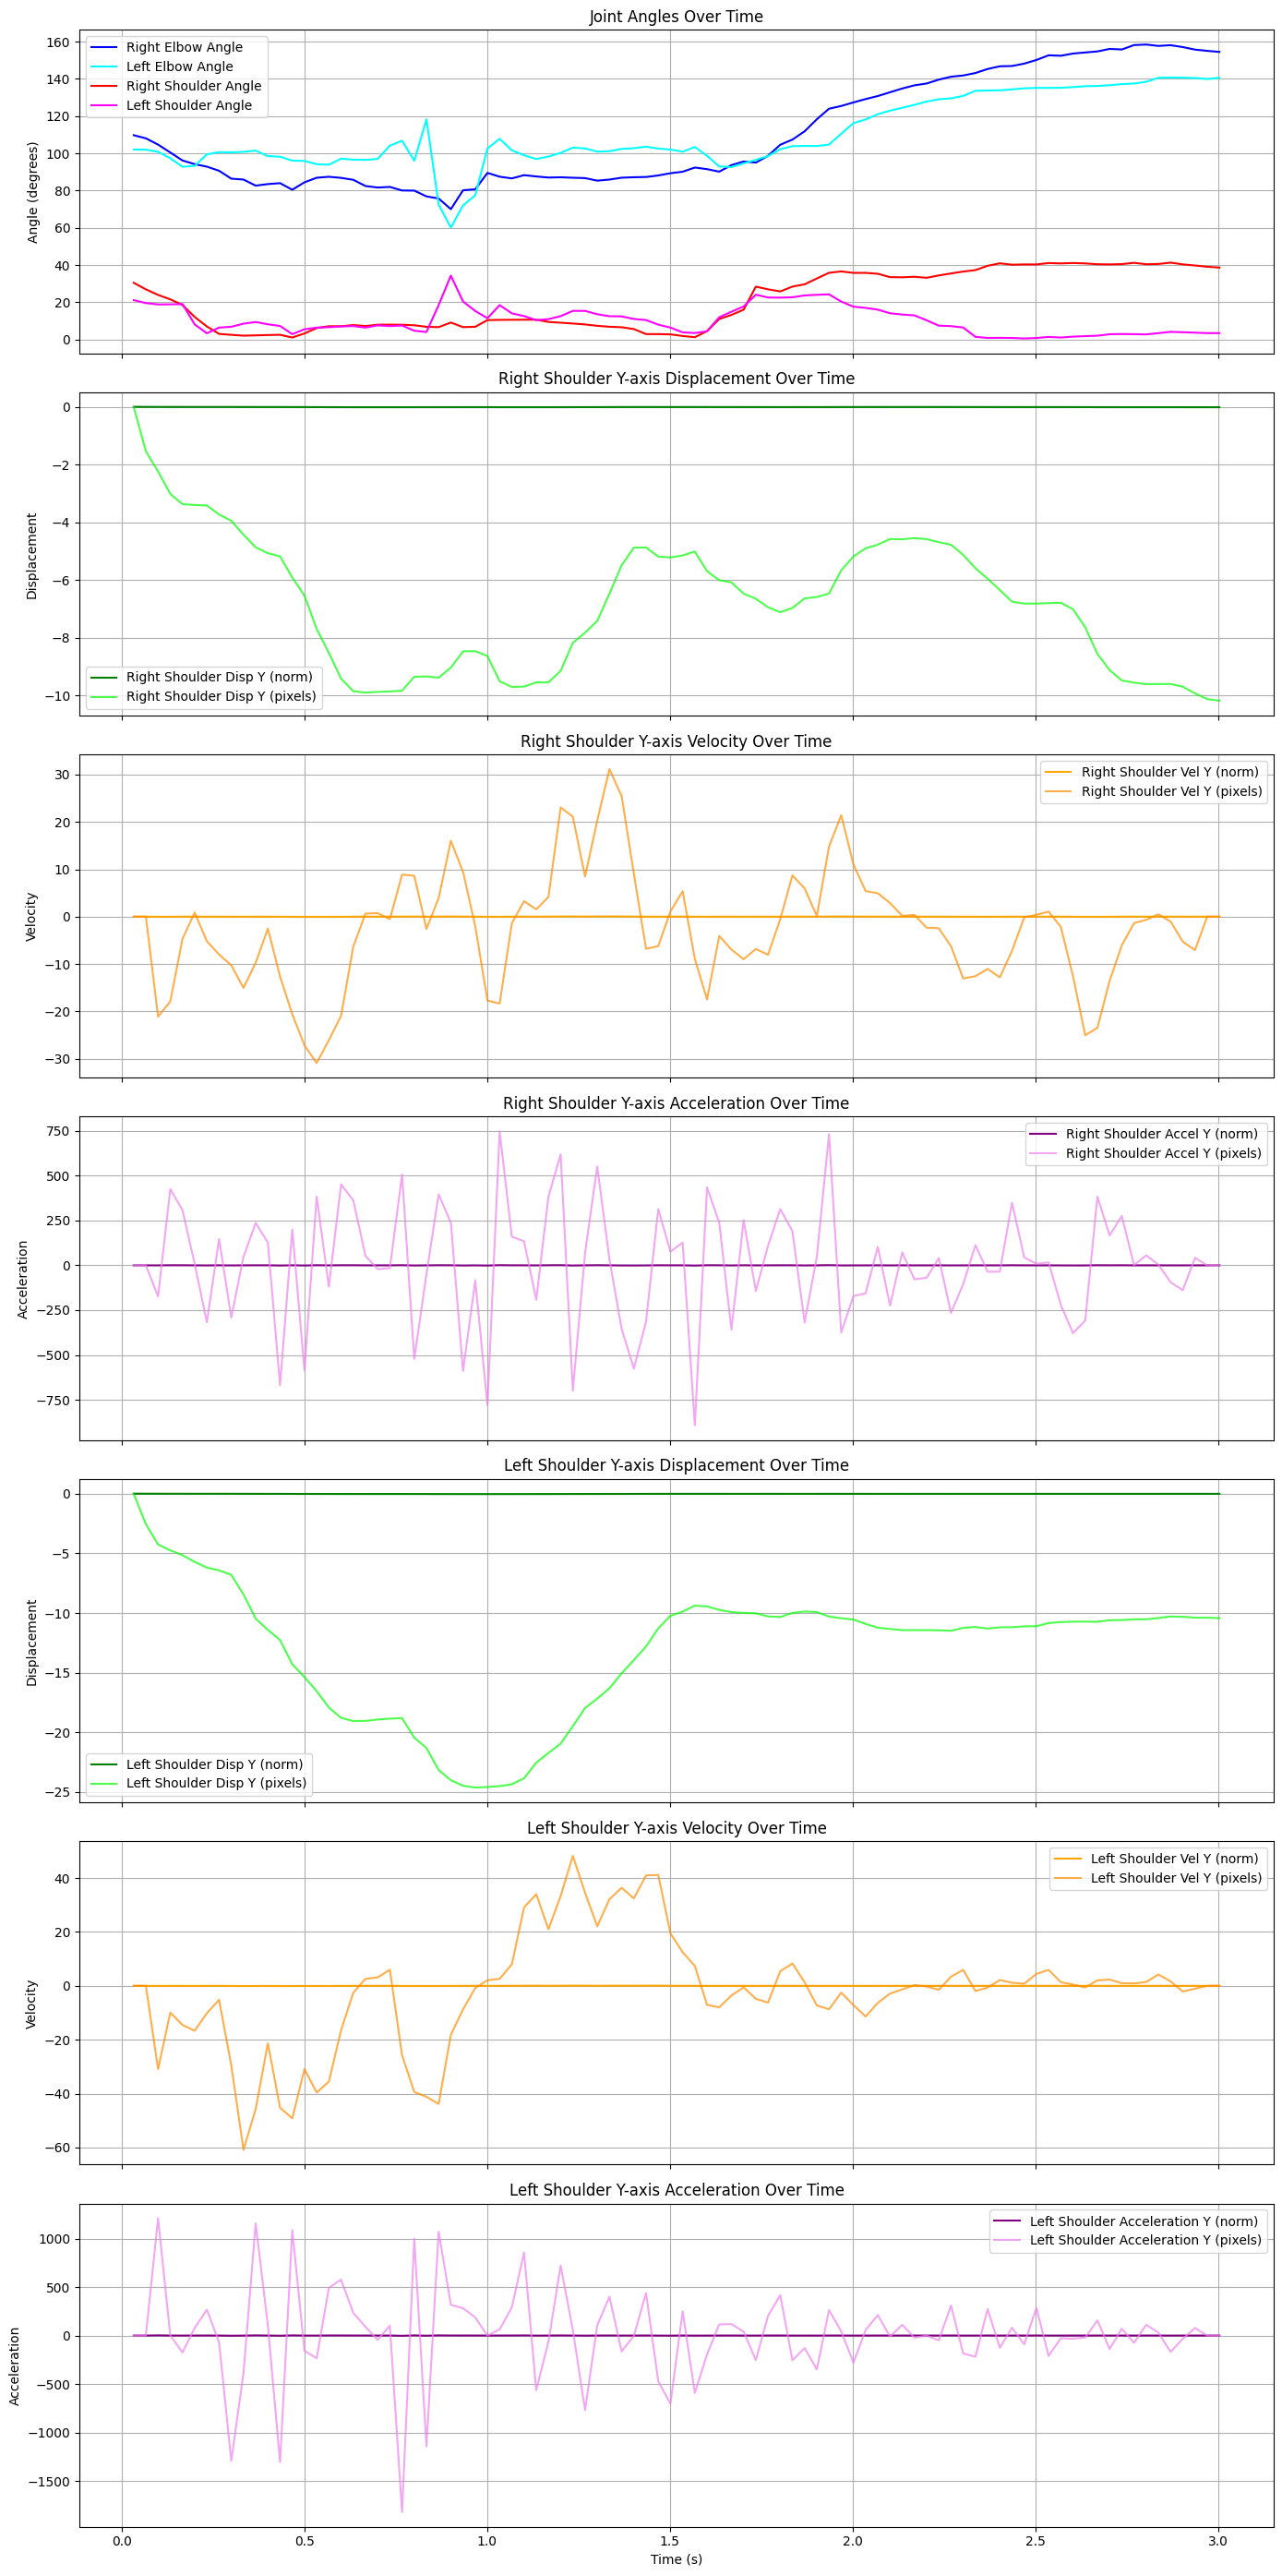

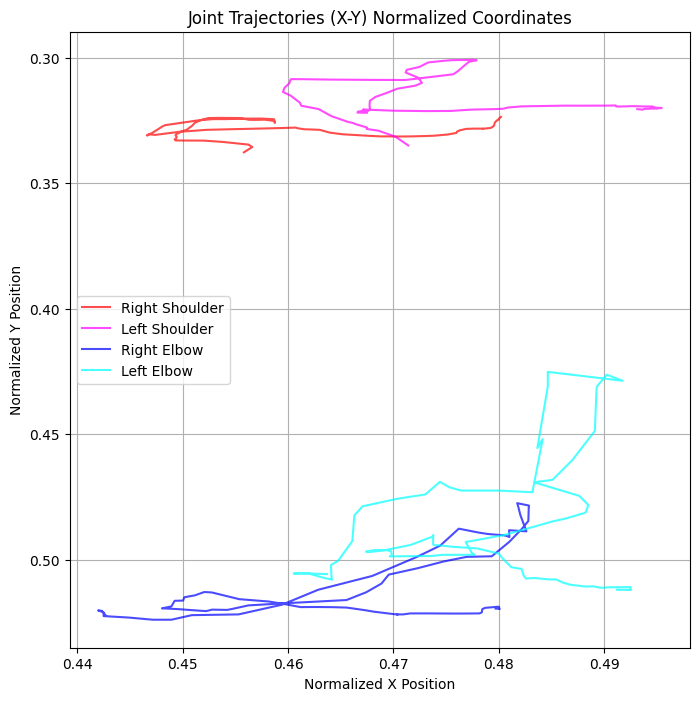

In [ ]:
# Required imports
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Upload video file in Google Colab environment
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]
print("Video uploaded as:", VIDEO_PATH)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Angle calculation function using three 3D points
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

data = []
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_num = 0

frame_width = None
frame_height = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1

    if frame_num == 1:
        frame_height, frame_width = frame.shape[:2]
        print(f"Video dimensions: width={frame_width}, height={frame_height}")

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        row = [frame_num]

        for lm in landmarks:
            row.extend([lm.x, lm.y, lm.z])

        # Calculate right elbow angle (shoulder=12, elbow=14, wrist=16)
        a = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        b = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        c = [landmarks[16].x, landmarks[16].y, landmarks[16].z]
        right_elbow_angle = calculate_angle(a, b, c)

        # Calculate left elbow angle (shoulder=11, elbow=13, wrist=15)
        a_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        b_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        c_l = [landmarks[15].x, landmarks[15].y, landmarks[15].z]
        left_elbow_angle = calculate_angle(a_l, b_l, c_l)

        # Calculate right shoulder angle (hip=24, shoulder=12, elbow=14)
        a_sh = [landmarks[24].x, landmarks[24].y, landmarks[24].z]
        b_sh = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        c_sh = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        right_shoulder_angle = calculate_angle(a_sh, b_sh, c_sh)

        # Calculate left shoulder angle (hip=23, shoulder=11, elbow=13)
        a_sh_l = [landmarks[23].x, landmarks[23].y, landmarks[23].z]
        b_sh_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        c_sh_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        left_shoulder_angle = calculate_angle(a_sh_l, b_sh_l, c_sh_l)

        # Append angles to row
        row.extend([right_elbow_angle, left_elbow_angle, right_shoulder_angle, left_shoulder_angle])

        data.append(row)

cap.release()
pose.close()

# Create DataFrame
columns = ['frame']
for i in range(33):
    columns += [f'lm{i}_x', f'lm{i}_y', f'lm{i}_z']
columns += ['right_elbow_angle_deg', 'left_elbow_angle_deg', 'right_shoulder_angle_deg', 'left_shoulder_angle_deg']
df = pd.DataFrame(data, columns=columns)

# Convert landmarks to float for shoulder landmarks (right and left)
df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']] = \
    df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']].astype(float)

# Calculate pixel coordinates for shoulder landmarks (right and left)
df['lm12_x_px'] = df['lm12_x'] * frame_width
df['lm12_y_px'] = df['lm12_y'] * frame_height
df['lm11_x_px'] = df['lm11_x'] * frame_width
df['lm11_y_px'] = df['lm11_y'] * frame_height

# Calculate displacement, velocity, and acceleration for right shoulder y (normalized and pixels)
df['shoulder_disp_y'] = df['lm12_y'].diff().fillna(0)
df['shoulder_disp_y_px'] = df['lm12_y_px'].diff().fillna(0)

h = 1.0 / fps

# Velocity (5-point central difference) y-axis normalized and pixel
df['shoulder_vy'] = (-df['lm12_y'].shift(-2) + 8*df['lm12_y'].shift(-1) - 8*df['lm12_y'].shift(1) + df['lm12_y'].shift(2)) / (12 * h)
df['shoulder_vy_px'] = (-df['lm12_y_px'].shift(-2) + 8*df['lm12_y_px'].shift(-1) - 8*df['lm12_y_px'].shift(1) + df['lm12_y_px'].shift(2)) / (12 * h)

# Acceleration (5-point central difference) y-axis normalized and pixel
df['shoulder_ay'] = (-df['lm12_y'].shift(-2) + 16*df['lm12_y'].shift(-1) - 30*df['lm12_y'] + 16*df['lm12_y'].shift(1) - df['lm12_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_px'] = (-df['lm12_y_px'].shift(-2) + 16*df['lm12_y_px'].shift(-1) - 30*df['lm12_y_px'] + 16*df['lm12_y_px'].shift(1) - df['lm12_y_px'].shift(2)) / (12 * h**2)

# Similarly for left shoulder y displacement etc.
df['shoulder_disp_y_left'] = df['lm11_y'].diff().fillna(0)
df['shoulder_disp_y_left_px'] = df['lm11_y_px'].diff().fillna(0)
df['shoulder_vy_left'] = (-df['lm11_y'].shift(-2) + 8*df['lm11_y'].shift(-1) - 8*df['lm11_y'].shift(1) + df['lm11_y'].shift(2)) / (12 * h)
df['shoulder_vy_left_px'] = (-df['lm11_y_px'].shift(-2) + 8*df['lm11_y_px'].shift(-1) - 8*df['lm11_y_px'].shift(1) + df['lm11_y_px'].shift(2)) / (12 * h)
df['shoulder_ay_left'] = (-df['lm11_y'].shift(-2) + 16*df['lm11_y'].shift(-1) - 30*df['lm11_y'] + 16*df['lm11_y'].shift(1) - df['lm11_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_left_px'] = (-df['lm11_y_px'].shift(-2) + 16*df['lm11_y_px'].shift(-1) - 30*df['lm11_y_px'] + 16*df['lm11_y_px'].shift(1) - df['lm11_y_px'].shift(2)) / (12 * h**2)

# Calculate time vector
df['time_s'] = df['frame'] / fps
df.fillna(0, inplace=True)

# Save to Excel
df.to_excel('velocity_pushup_updated.xlsx', index=False)
print("Done! Data saved to velocity_pushup_updated.xlsx")

# --- Plotting ---

# Create 7 subplots to include left shoulder acceleration
fig, axs = plt.subplots(7, 1, figsize=(14, 28), sharex=True)

# 1. Angles (Right and Left Elbow, Shoulder)
axs[0].plot(df['time_s'], df['right_elbow_angle_deg'], label='Right Elbow Angle', color='blue')
axs[0].plot(df['time_s'], df['left_elbow_angle_deg'], label='Left Elbow Angle', color='cyan')
axs[0].plot(df['time_s'], df['right_shoulder_angle_deg'], label='Right Shoulder Angle', color='red')
axs[0].plot(df['time_s'], df['left_shoulder_angle_deg'], label='Left Shoulder Angle', color='magenta')
axs[0].set_ylabel('Angle (degrees)')
axs[0].set_title('Joint Angles Over Time')
axs[0].legend()
axs[0].grid()

# 2. Right Shoulder Y Displacement (normalized and pixels)
axs[1].plot(df['time_s'], df['shoulder_disp_y'].cumsum(), label='Right Shoulder Disp Y (norm)', color='green')
axs[1].plot(df['time_s'], df['shoulder_disp_y_px'].cumsum(), label='Right Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[1].set_ylabel('Displacement')
axs[1].set_title('Right Shoulder Y-axis Displacement Over Time')
axs[1].legend()
axs[1].grid()

# 3. Right Shoulder Y Velocity (normalized and pixels)
axs[2].plot(df['time_s'], df['shoulder_vy'], label='Right Shoulder Vel Y (norm)', color='orange')
axs[2].plot(df['time_s'], df['shoulder_vy_px'], label='Right Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[2].set_ylabel('Velocity')
axs[2].set_title('Right Shoulder Y-axis Velocity Over Time')
axs[2].legend()
axs[2].grid()

# 4. Right Shoulder Y Acceleration (normalized and pixels)
axs[3].plot(df['time_s'], df['shoulder_ay'], label='Right Shoulder Accel Y (norm)', color='purple')
axs[3].plot(df['time_s'], df['shoulder_ay_px'], label='Right Shoulder Accel Y (pixels)', color='violet', alpha=0.7)
axs[3].set_ylabel('Acceleration')
axs[3].set_title('Right Shoulder Y-axis Acceleration Over Time')
axs[3].legend()
axs[3].grid()

# 5. Left Shoulder Y Displacement (normalized and pixels)
axs[4].plot(df['time_s'], df['shoulder_disp_y_left'].cumsum(), label='Left Shoulder Disp Y (norm)', color='green')
axs[4].plot(df['time_s'], df['shoulder_disp_y_left_px'].cumsum(), label='Left Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[4].set_ylabel('Displacement')
axs[4].set_title('Left Shoulder Y-axis Displacement Over Time')
axs[4].legend()
axs[4].grid()

# 6. Left Shoulder Y Velocity (normalized and pixels)
axs[5].plot(df['time_s'], df['shoulder_vy_left'], label='Left Shoulder Vel Y (norm)', color='orange')
axs[5].plot(df['time_s'], df['shoulder_vy_left_px'], label='Left Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[5].set_ylabel('Velocity')
axs[5].set_title('Left Shoulder Y-axis Velocity Over Time')
axs[5].legend()
axs[5].grid()

# 7. Left Shoulder Y Acceleration (normalized and pixels)
axs[6].plot(df['time_s'], df['shoulder_ay_left'], label='Left Shoulder Acceleration Y (norm)', color='purple')
axs[6].plot(df['time_s'], df['shoulder_ay_left_px'], label='Left Shoulder Acceleration Y (pixels)', color='violet', alpha=0.7)
axs[6].set_xlabel('Time (s)')
axs[6].set_ylabel('Acceleration')
axs[6].set_title('Left Shoulder Y-axis Acceleration Over Time')
axs[6].legend()
axs[6].grid()

plt.tight_layout()
plt.show()

# --- Plot x-y Trajectory for shoulders and elbows (normalized) ---

plt.figure(figsize=(8,8))
plt.plot(df['lm12_x'], df['lm12_y'], label='Right Shoulder', color='red', alpha=0.7)
plt.plot(df['lm11_x'], df['lm11_y'], label='Left Shoulder', color='magenta', alpha=0.7)
plt.plot(df['lm14_x'], df['lm14_y'], label='Right Elbow', color='blue', alpha=0.7)
plt.plot(df['lm13_x'], df['lm13_y'], label='Left Elbow', color='cyan', alpha=0.7)
plt.gca().invert_yaxis()  # Optional: invert y-axis if you want top of image as top
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.title('Joint Trajectories (X-Y) Normalized Coordinates')
plt.legend()
plt.grid()
plt.show()


4. bench press

Saving bench press_10.mp4 to bench press_10.mp4
Video uploaded as: bench press_10.mp4
Video dimensions: width=1920, height=1080
Done! Data saved to velocity_pushup_updated.xlsx


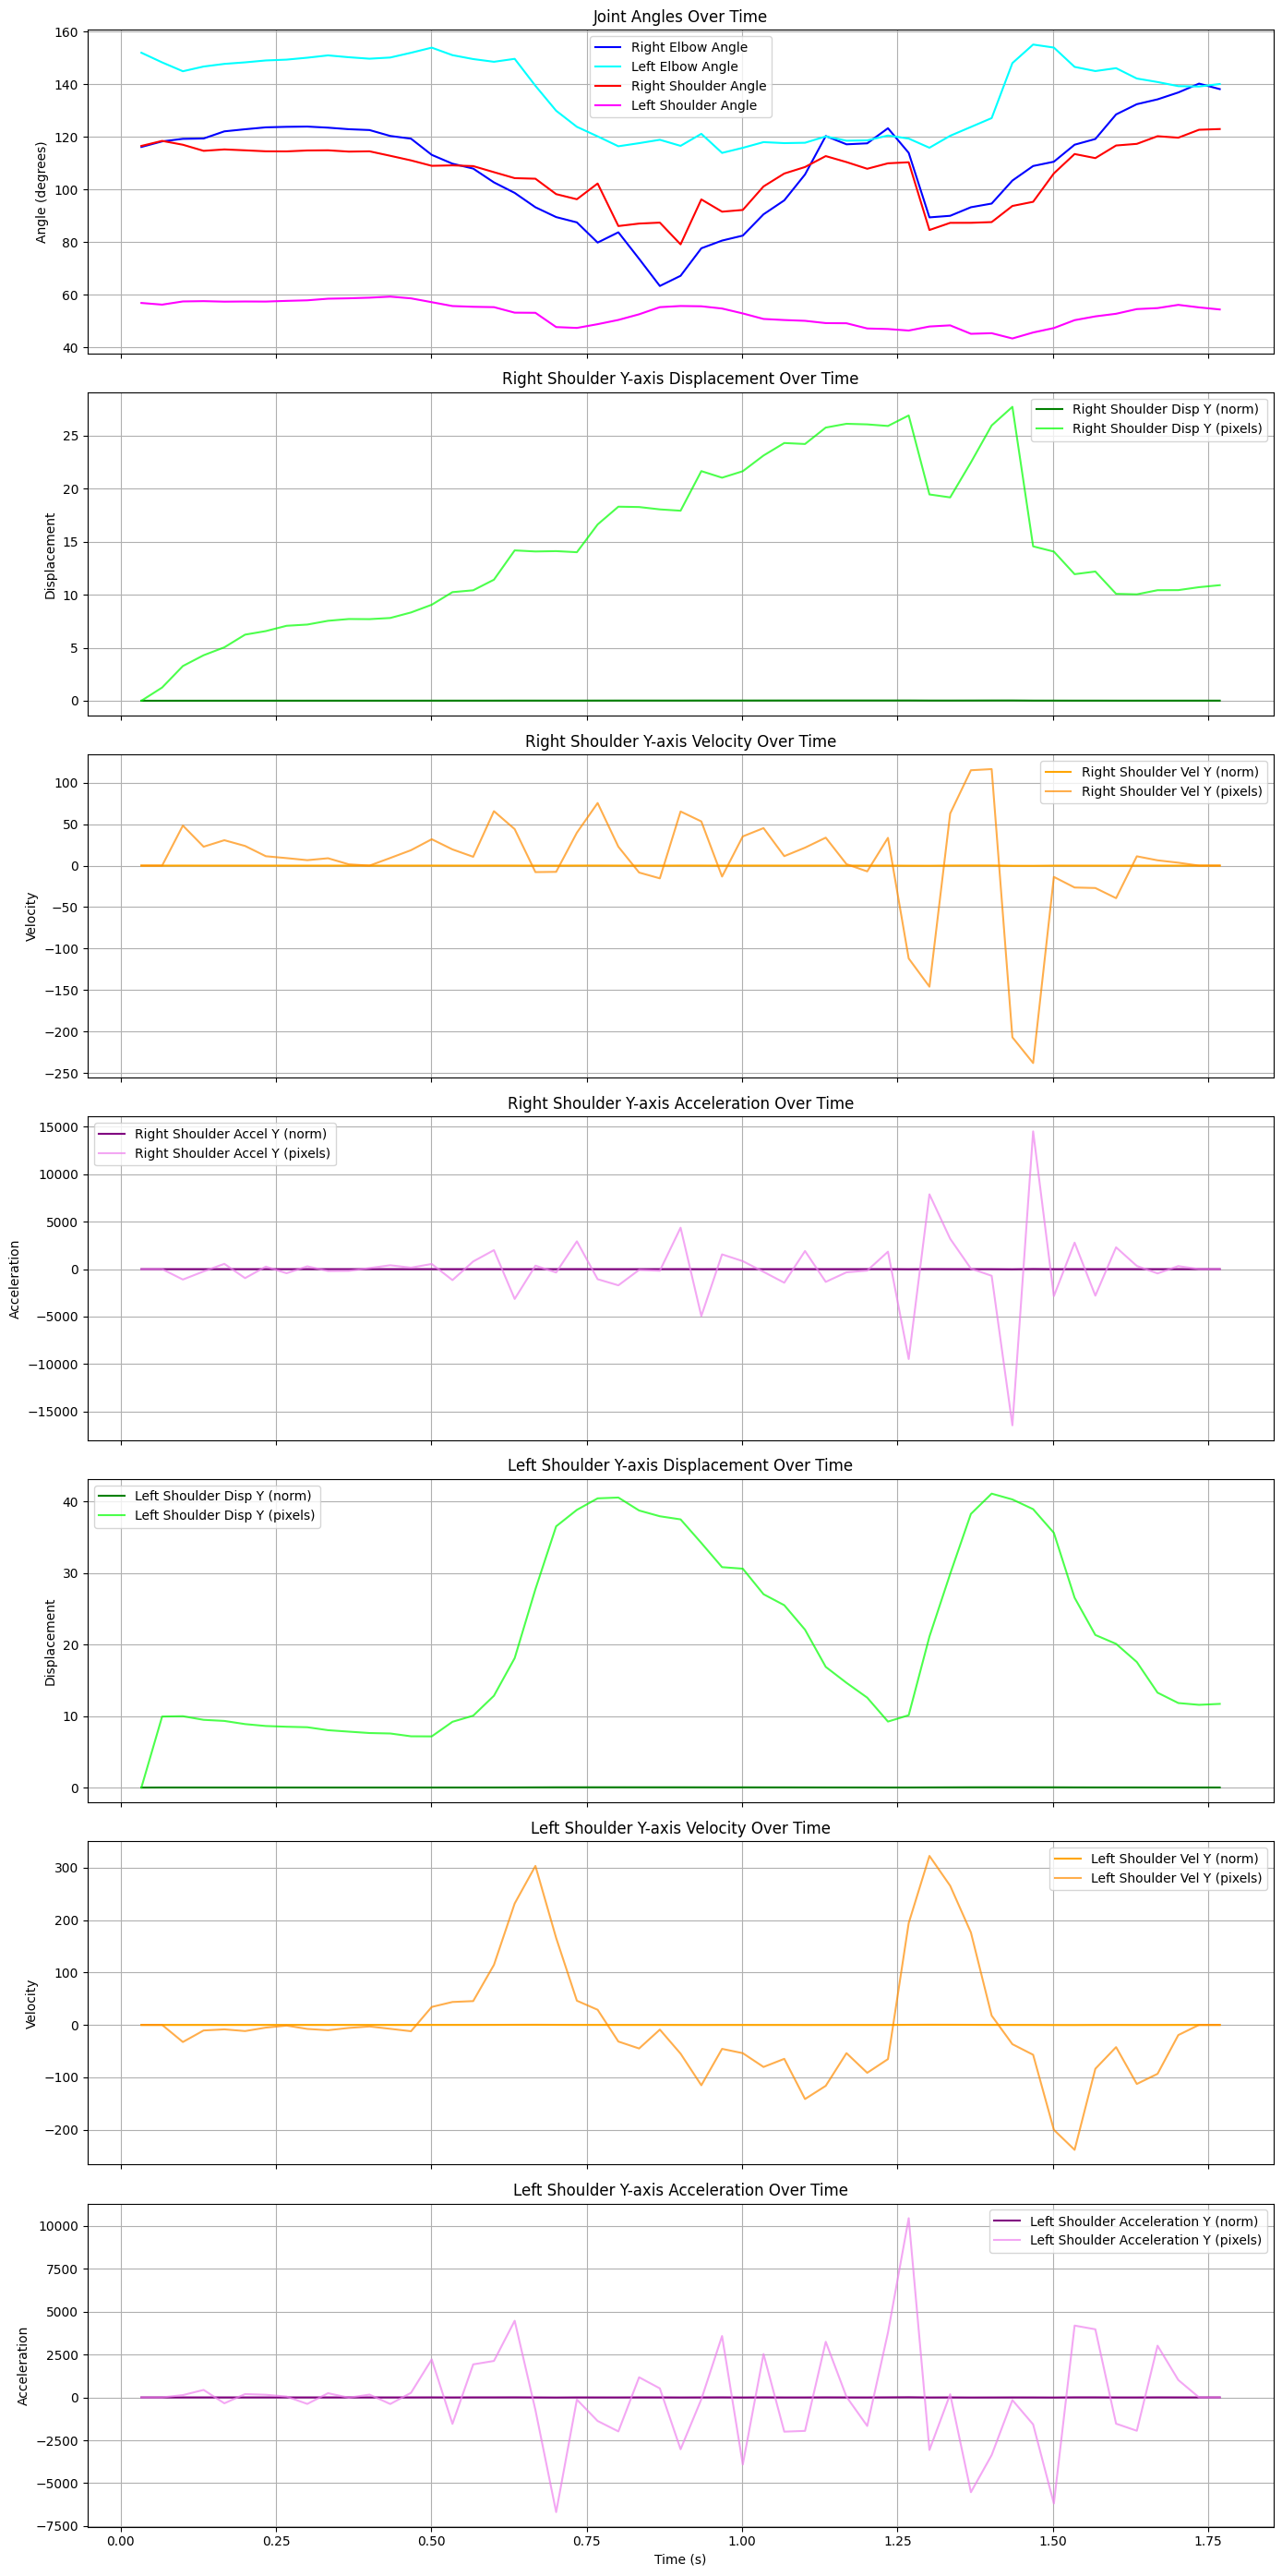

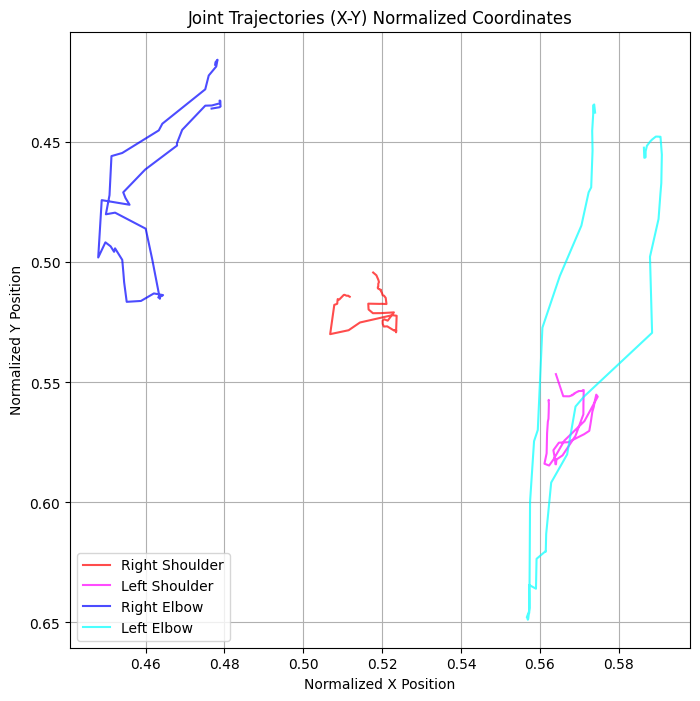

In [ ]:
# Required imports
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Upload video file in Google Colab environment
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]
print("Video uploaded as:", VIDEO_PATH)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Angle calculation function using three 3D points
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

data = []
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_num = 0

frame_width = None
frame_height = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1

    if frame_num == 1:
        frame_height, frame_width = frame.shape[:2]
        print(f"Video dimensions: width={frame_width}, height={frame_height}")

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        row = [frame_num]

        for lm in landmarks:
            row.extend([lm.x, lm.y, lm.z])

        # Calculate right elbow angle (shoulder=12, elbow=14, wrist=16)
        a = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        b = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        c = [landmarks[16].x, landmarks[16].y, landmarks[16].z]
        right_elbow_angle = calculate_angle(a, b, c)

        # Calculate left elbow angle (shoulder=11, elbow=13, wrist=15)
        a_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        b_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        c_l = [landmarks[15].x, landmarks[15].y, landmarks[15].z]
        left_elbow_angle = calculate_angle(a_l, b_l, c_l)

        # Calculate right shoulder angle (hip=24, shoulder=12, elbow=14)
        a_sh = [landmarks[24].x, landmarks[24].y, landmarks[24].z]
        b_sh = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        c_sh = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        right_shoulder_angle = calculate_angle(a_sh, b_sh, c_sh)

        # Calculate left shoulder angle (hip=23, shoulder=11, elbow=13)
        a_sh_l = [landmarks[23].x, landmarks[23].y, landmarks[23].z]
        b_sh_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        c_sh_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        left_shoulder_angle = calculate_angle(a_sh_l, b_sh_l, c_sh_l)

        # Append angles to row
        row.extend([right_elbow_angle, left_elbow_angle, right_shoulder_angle, left_shoulder_angle])

        data.append(row)

cap.release()
pose.close()

# Create DataFrame
columns = ['frame']
for i in range(33):
    columns += [f'lm{i}_x', f'lm{i}_y', f'lm{i}_z']
columns += ['right_elbow_angle_deg', 'left_elbow_angle_deg', 'right_shoulder_angle_deg', 'left_shoulder_angle_deg']
df = pd.DataFrame(data, columns=columns)

# Convert landmarks to float for shoulder landmarks (right and left)
df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']] = \
    df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']].astype(float)

# Calculate pixel coordinates for shoulder landmarks (right and left)
df['lm12_x_px'] = df['lm12_x'] * frame_width
df['lm12_y_px'] = df['lm12_y'] * frame_height
df['lm11_x_px'] = df['lm11_x'] * frame_width
df['lm11_y_px'] = df['lm11_y'] * frame_height

# Calculate displacement, velocity, and acceleration for right shoulder y (normalized and pixels)
df['shoulder_disp_y'] = df['lm12_y'].diff().fillna(0)
df['shoulder_disp_y_px'] = df['lm12_y_px'].diff().fillna(0)

h = 1.0 / fps

# Velocity (5-point central difference) y-axis normalized and pixel
df['shoulder_vy'] = (-df['lm12_y'].shift(-2) + 8*df['lm12_y'].shift(-1) - 8*df['lm12_y'].shift(1) + df['lm12_y'].shift(2)) / (12 * h)
df['shoulder_vy_px'] = (-df['lm12_y_px'].shift(-2) + 8*df['lm12_y_px'].shift(-1) - 8*df['lm12_y_px'].shift(1) + df['lm12_y_px'].shift(2)) / (12 * h)

# Acceleration (5-point central difference) y-axis normalized and pixel
df['shoulder_ay'] = (-df['lm12_y'].shift(-2) + 16*df['lm12_y'].shift(-1) - 30*df['lm12_y'] + 16*df['lm12_y'].shift(1) - df['lm12_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_px'] = (-df['lm12_y_px'].shift(-2) + 16*df['lm12_y_px'].shift(-1) - 30*df['lm12_y_px'] + 16*df['lm12_y_px'].shift(1) - df['lm12_y_px'].shift(2)) / (12 * h**2)

# Similarly for left shoulder y displacement etc.
df['shoulder_disp_y_left'] = df['lm11_y'].diff().fillna(0)
df['shoulder_disp_y_left_px'] = df['lm11_y_px'].diff().fillna(0)
df['shoulder_vy_left'] = (-df['lm11_y'].shift(-2) + 8*df['lm11_y'].shift(-1) - 8*df['lm11_y'].shift(1) + df['lm11_y'].shift(2)) / (12 * h)
df['shoulder_vy_left_px'] = (-df['lm11_y_px'].shift(-2) + 8*df['lm11_y_px'].shift(-1) - 8*df['lm11_y_px'].shift(1) + df['lm11_y_px'].shift(2)) / (12 * h)
df['shoulder_ay_left'] = (-df['lm11_y'].shift(-2) + 16*df['lm11_y'].shift(-1) - 30*df['lm11_y'] + 16*df['lm11_y'].shift(1) - df['lm11_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_left_px'] = (-df['lm11_y_px'].shift(-2) + 16*df['lm11_y_px'].shift(-1) - 30*df['lm11_y_px'] + 16*df['lm11_y_px'].shift(1) - df['lm11_y_px'].shift(2)) / (12 * h**2)

# Calculate time vector
df['time_s'] = df['frame'] / fps
df.fillna(0, inplace=True)

# Save to Excel
df.to_excel('velocity_pushup_updated.xlsx', index=False)
print("Done! Data saved to velocity_pushup_updated.xlsx")

# --- Plotting ---

# Create 7 subplots to include left shoulder acceleration
fig, axs = plt.subplots(7, 1, figsize=(14, 28), sharex=True)

# 1. Angles (Right and Left Elbow, Shoulder)
axs[0].plot(df['time_s'], df['right_elbow_angle_deg'], label='Right Elbow Angle', color='blue')
axs[0].plot(df['time_s'], df['left_elbow_angle_deg'], label='Left Elbow Angle', color='cyan')
axs[0].plot(df['time_s'], df['right_shoulder_angle_deg'], label='Right Shoulder Angle', color='red')
axs[0].plot(df['time_s'], df['left_shoulder_angle_deg'], label='Left Shoulder Angle', color='magenta')
axs[0].set_ylabel('Angle (degrees)')
axs[0].set_title('Joint Angles Over Time')
axs[0].legend()
axs[0].grid()

# 2. Right Shoulder Y Displacement (normalized and pixels)
axs[1].plot(df['time_s'], df['shoulder_disp_y'].cumsum(), label='Right Shoulder Disp Y (norm)', color='green')
axs[1].plot(df['time_s'], df['shoulder_disp_y_px'].cumsum(), label='Right Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[1].set_ylabel('Displacement')
axs[1].set_title('Right Shoulder Y-axis Displacement Over Time')
axs[1].legend()
axs[1].grid()

# 3. Right Shoulder Y Velocity (normalized and pixels)
axs[2].plot(df['time_s'], df['shoulder_vy'], label='Right Shoulder Vel Y (norm)', color='orange')
axs[2].plot(df['time_s'], df['shoulder_vy_px'], label='Right Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[2].set_ylabel('Velocity')
axs[2].set_title('Right Shoulder Y-axis Velocity Over Time')
axs[2].legend()
axs[2].grid()

# 4. Right Shoulder Y Acceleration (normalized and pixels)
axs[3].plot(df['time_s'], df['shoulder_ay'], label='Right Shoulder Accel Y (norm)', color='purple')
axs[3].plot(df['time_s'], df['shoulder_ay_px'], label='Right Shoulder Accel Y (pixels)', color='violet', alpha=0.7)
axs[3].set_ylabel('Acceleration')
axs[3].set_title('Right Shoulder Y-axis Acceleration Over Time')
axs[3].legend()
axs[3].grid()

# 5. Left Shoulder Y Displacement (normalized and pixels)
axs[4].plot(df['time_s'], df['shoulder_disp_y_left'].cumsum(), label='Left Shoulder Disp Y (norm)', color='green')
axs[4].plot(df['time_s'], df['shoulder_disp_y_left_px'].cumsum(), label='Left Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[4].set_ylabel('Displacement')
axs[4].set_title('Left Shoulder Y-axis Displacement Over Time')
axs[4].legend()
axs[4].grid()

# 6. Left Shoulder Y Velocity (normalized and pixels)
axs[5].plot(df['time_s'], df['shoulder_vy_left'], label='Left Shoulder Vel Y (norm)', color='orange')
axs[5].plot(df['time_s'], df['shoulder_vy_left_px'], label='Left Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[5].set_ylabel('Velocity')
axs[5].set_title('Left Shoulder Y-axis Velocity Over Time')
axs[5].legend()
axs[5].grid()

# 7. Left Shoulder Y Acceleration (normalized and pixels)
axs[6].plot(df['time_s'], df['shoulder_ay_left'], label='Left Shoulder Acceleration Y (norm)', color='purple')
axs[6].plot(df['time_s'], df['shoulder_ay_left_px'], label='Left Shoulder Acceleration Y (pixels)', color='violet', alpha=0.7)
axs[6].set_xlabel('Time (s)')
axs[6].set_ylabel('Acceleration')
axs[6].set_title('Left Shoulder Y-axis Acceleration Over Time')
axs[6].legend()
axs[6].grid()

plt.tight_layout()
plt.show()

# --- Plot x-y Trajectory for shoulders and elbows (normalized) ---

plt.figure(figsize=(8,8))
plt.plot(df['lm12_x'], df['lm12_y'], label='Right Shoulder', color='red', alpha=0.7)
plt.plot(df['lm11_x'], df['lm11_y'], label='Left Shoulder', color='magenta', alpha=0.7)
plt.plot(df['lm14_x'], df['lm14_y'], label='Right Elbow', color='blue', alpha=0.7)
plt.plot(df['lm13_x'], df['lm13_y'], label='Left Elbow', color='cyan', alpha=0.7)
plt.gca().invert_yaxis()  # Optional: invert y-axis if you want top of image as top
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.title('Joint Trajectories (X-Y) Normalized Coordinates')
plt.legend()
plt.grid()
plt.show()


5. shoulder press

Saving shoulder press_16.mp4 to shoulder press_16.mp4
Video uploaded as: shoulder press_16.mp4
Video dimensions: width=1280, height=720
Done! Data saved to velocity_pushup_updated.xlsx


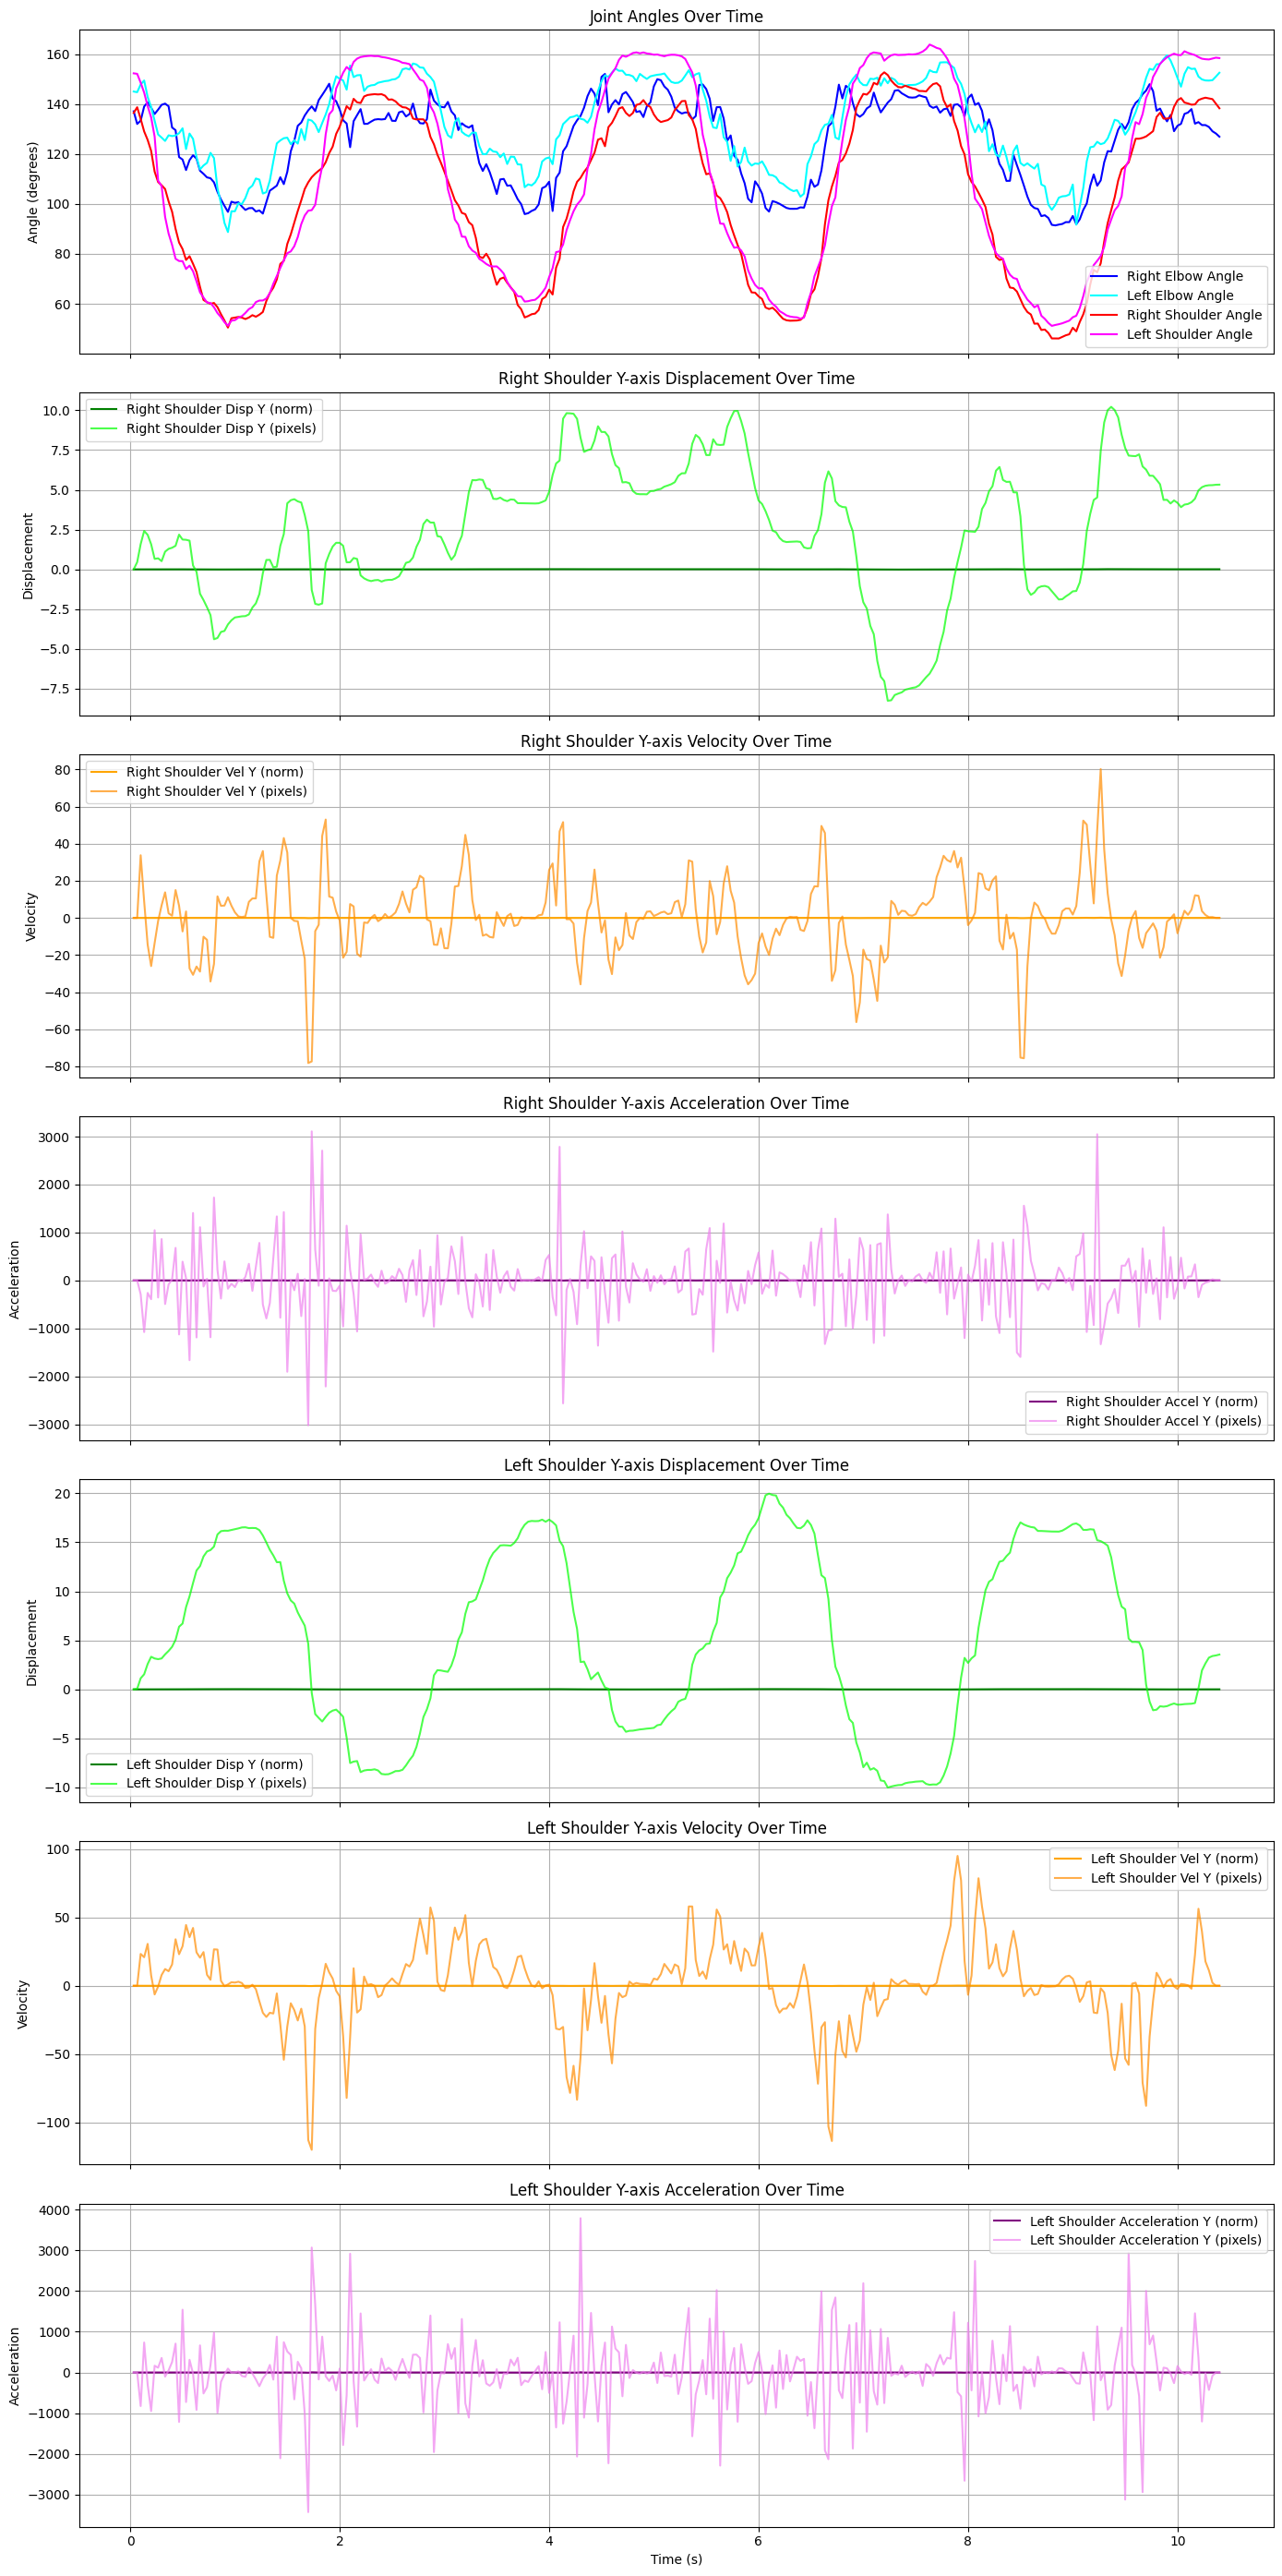

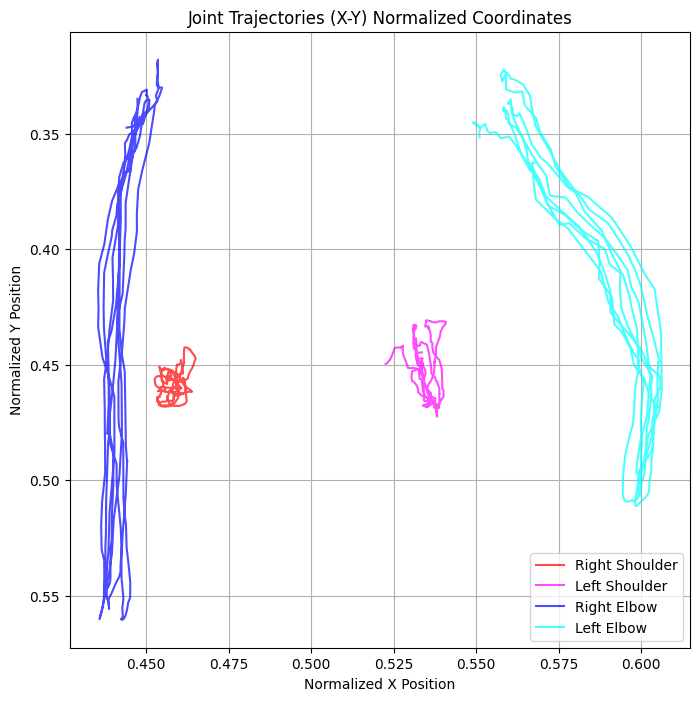

In [ ]:
# Required imports
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Upload video file in Google Colab environment
uploaded = files.upload()
VIDEO_PATH = list(uploaded.keys())[0]
print("Video uploaded as:", VIDEO_PATH)

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Angle calculation function using three 3D points
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return np.degrees(angle)

data = []
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_num = 0

frame_width = None
frame_height = None

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_num += 1

    if frame_num == 1:
        frame_height, frame_width = frame.shape[:2]
        print(f"Video dimensions: width={frame_width}, height={frame_height}")

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb)
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark
        row = [frame_num]

        for lm in landmarks:
            row.extend([lm.x, lm.y, lm.z])

        # Calculate right elbow angle (shoulder=12, elbow=14, wrist=16)
        a = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        b = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        c = [landmarks[16].x, landmarks[16].y, landmarks[16].z]
        right_elbow_angle = calculate_angle(a, b, c)

        # Calculate left elbow angle (shoulder=11, elbow=13, wrist=15)
        a_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        b_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        c_l = [landmarks[15].x, landmarks[15].y, landmarks[15].z]
        left_elbow_angle = calculate_angle(a_l, b_l, c_l)

        # Calculate right shoulder angle (hip=24, shoulder=12, elbow=14)
        a_sh = [landmarks[24].x, landmarks[24].y, landmarks[24].z]
        b_sh = [landmarks[12].x, landmarks[12].y, landmarks[12].z]
        c_sh = [landmarks[14].x, landmarks[14].y, landmarks[14].z]
        right_shoulder_angle = calculate_angle(a_sh, b_sh, c_sh)

        # Calculate left shoulder angle (hip=23, shoulder=11, elbow=13)
        a_sh_l = [landmarks[23].x, landmarks[23].y, landmarks[23].z]
        b_sh_l = [landmarks[11].x, landmarks[11].y, landmarks[11].z]
        c_sh_l = [landmarks[13].x, landmarks[13].y, landmarks[13].z]
        left_shoulder_angle = calculate_angle(a_sh_l, b_sh_l, c_sh_l)

        # Append angles to row
        row.extend([right_elbow_angle, left_elbow_angle, right_shoulder_angle, left_shoulder_angle])

        data.append(row)

cap.release()
pose.close()

# Create DataFrame
columns = ['frame']
for i in range(33):
    columns += [f'lm{i}_x', f'lm{i}_y', f'lm{i}_z']
columns += ['right_elbow_angle_deg', 'left_elbow_angle_deg', 'right_shoulder_angle_deg', 'left_shoulder_angle_deg']
df = pd.DataFrame(data, columns=columns)

# Convert landmarks to float for shoulder landmarks (right and left)
df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']] = \
    df[['lm12_x', 'lm12_y', 'lm12_z', 'lm11_x', 'lm11_y', 'lm11_z']].astype(float)

# Calculate pixel coordinates for shoulder landmarks (right and left)
df['lm12_x_px'] = df['lm12_x'] * frame_width
df['lm12_y_px'] = df['lm12_y'] * frame_height
df['lm11_x_px'] = df['lm11_x'] * frame_width
df['lm11_y_px'] = df['lm11_y'] * frame_height

# Calculate displacement, velocity, and acceleration for right shoulder y (normalized and pixels)
df['shoulder_disp_y'] = df['lm12_y'].diff().fillna(0)
df['shoulder_disp_y_px'] = df['lm12_y_px'].diff().fillna(0)

h = 1.0 / fps

# Velocity (5-point central difference) y-axis normalized and pixel
df['shoulder_vy'] = (-df['lm12_y'].shift(-2) + 8*df['lm12_y'].shift(-1) - 8*df['lm12_y'].shift(1) + df['lm12_y'].shift(2)) / (12 * h)
df['shoulder_vy_px'] = (-df['lm12_y_px'].shift(-2) + 8*df['lm12_y_px'].shift(-1) - 8*df['lm12_y_px'].shift(1) + df['lm12_y_px'].shift(2)) / (12 * h)

# Acceleration (5-point central difference) y-axis normalized and pixel
df['shoulder_ay'] = (-df['lm12_y'].shift(-2) + 16*df['lm12_y'].shift(-1) - 30*df['lm12_y'] + 16*df['lm12_y'].shift(1) - df['lm12_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_px'] = (-df['lm12_y_px'].shift(-2) + 16*df['lm12_y_px'].shift(-1) - 30*df['lm12_y_px'] + 16*df['lm12_y_px'].shift(1) - df['lm12_y_px'].shift(2)) / (12 * h**2)

# Similarly for left shoulder y displacement etc.
df['shoulder_disp_y_left'] = df['lm11_y'].diff().fillna(0)
df['shoulder_disp_y_left_px'] = df['lm11_y_px'].diff().fillna(0)
df['shoulder_vy_left'] = (-df['lm11_y'].shift(-2) + 8*df['lm11_y'].shift(-1) - 8*df['lm11_y'].shift(1) + df['lm11_y'].shift(2)) / (12 * h)
df['shoulder_vy_left_px'] = (-df['lm11_y_px'].shift(-2) + 8*df['lm11_y_px'].shift(-1) - 8*df['lm11_y_px'].shift(1) + df['lm11_y_px'].shift(2)) / (12 * h)
df['shoulder_ay_left'] = (-df['lm11_y'].shift(-2) + 16*df['lm11_y'].shift(-1) - 30*df['lm11_y'] + 16*df['lm11_y'].shift(1) - df['lm11_y'].shift(2)) / (12 * h**2)
df['shoulder_ay_left_px'] = (-df['lm11_y_px'].shift(-2) + 16*df['lm11_y_px'].shift(-1) - 30*df['lm11_y_px'] + 16*df['lm11_y_px'].shift(1) - df['lm11_y_px'].shift(2)) / (12 * h**2)

# Calculate time vector
df['time_s'] = df['frame'] / fps
df.fillna(0, inplace=True)

# Save to Excel
df.to_excel('velocity_pushup_updated.xlsx', index=False)
print("Done! Data saved to velocity_pushup_updated.xlsx")

# --- Plotting ---

# Create 7 subplots to include left shoulder acceleration
fig, axs = plt.subplots(7, 1, figsize=(14, 28), sharex=True)

# 1. Angles (Right and Left Elbow, Shoulder)
axs[0].plot(df['time_s'], df['right_elbow_angle_deg'], label='Right Elbow Angle', color='blue')
axs[0].plot(df['time_s'], df['left_elbow_angle_deg'], label='Left Elbow Angle', color='cyan')
axs[0].plot(df['time_s'], df['right_shoulder_angle_deg'], label='Right Shoulder Angle', color='red')
axs[0].plot(df['time_s'], df['left_shoulder_angle_deg'], label='Left Shoulder Angle', color='magenta')
axs[0].set_ylabel('Angle (degrees)')
axs[0].set_title('Joint Angles Over Time')
axs[0].legend()
axs[0].grid()

# 2. Right Shoulder Y Displacement (normalized and pixels)
axs[1].plot(df['time_s'], df['shoulder_disp_y'].cumsum(), label='Right Shoulder Disp Y (norm)', color='green')
axs[1].plot(df['time_s'], df['shoulder_disp_y_px'].cumsum(), label='Right Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[1].set_ylabel('Displacement')
axs[1].set_title('Right Shoulder Y-axis Displacement Over Time')
axs[1].legend()
axs[1].grid()

# 3. Right Shoulder Y Velocity (normalized and pixels)
axs[2].plot(df['time_s'], df['shoulder_vy'], label='Right Shoulder Vel Y (norm)', color='orange')
axs[2].plot(df['time_s'], df['shoulder_vy_px'], label='Right Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[2].set_ylabel('Velocity')
axs[2].set_title('Right Shoulder Y-axis Velocity Over Time')
axs[2].legend()
axs[2].grid()

# 4. Right Shoulder Y Acceleration (normalized and pixels)
axs[3].plot(df['time_s'], df['shoulder_ay'], label='Right Shoulder Accel Y (norm)', color='purple')
axs[3].plot(df['time_s'], df['shoulder_ay_px'], label='Right Shoulder Accel Y (pixels)', color='violet', alpha=0.7)
axs[3].set_ylabel('Acceleration')
axs[3].set_title('Right Shoulder Y-axis Acceleration Over Time')
axs[3].legend()
axs[3].grid()

# 5. Left Shoulder Y Displacement (normalized and pixels)
axs[4].plot(df['time_s'], df['shoulder_disp_y_left'].cumsum(), label='Left Shoulder Disp Y (norm)', color='green')
axs[4].plot(df['time_s'], df['shoulder_disp_y_left_px'].cumsum(), label='Left Shoulder Disp Y (pixels)', color='lime', alpha=0.7)
axs[4].set_ylabel('Displacement')
axs[4].set_title('Left Shoulder Y-axis Displacement Over Time')
axs[4].legend()
axs[4].grid()

# 6. Left Shoulder Y Velocity (normalized and pixels)
axs[5].plot(df['time_s'], df['shoulder_vy_left'], label='Left Shoulder Vel Y (norm)', color='orange')
axs[5].plot(df['time_s'], df['shoulder_vy_left_px'], label='Left Shoulder Vel Y (pixels)', color='darkorange', alpha=0.7)
axs[5].set_ylabel('Velocity')
axs[5].set_title('Left Shoulder Y-axis Velocity Over Time')
axs[5].legend()
axs[5].grid()

# 7. Left Shoulder Y Acceleration (normalized and pixels)
axs[6].plot(df['time_s'], df['shoulder_ay_left'], label='Left Shoulder Acceleration Y (norm)', color='purple')
axs[6].plot(df['time_s'], df['shoulder_ay_left_px'], label='Left Shoulder Acceleration Y (pixels)', color='violet', alpha=0.7)
axs[6].set_xlabel('Time (s)')
axs[6].set_ylabel('Acceleration')
axs[6].set_title('Left Shoulder Y-axis Acceleration Over Time')
axs[6].legend()
axs[6].grid()

plt.tight_layout()
plt.show()

# --- Plot x-y Trajectory for shoulders and elbows (normalized) ---

plt.figure(figsize=(8,8))
plt.plot(df['lm12_x'], df['lm12_y'], label='Right Shoulder', color='red', alpha=0.7)
plt.plot(df['lm11_x'], df['lm11_y'], label='Left Shoulder', color='magenta', alpha=0.7)
plt.plot(df['lm14_x'], df['lm14_y'], label='Right Elbow', color='blue', alpha=0.7)
plt.plot(df['lm13_x'], df['lm13_y'], label='Left Elbow', color='cyan', alpha=0.7)
plt.gca().invert_yaxis()  # Optional: invert y-axis if you want top of image as top
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.title('Joint Trajectories (X-Y) Normalized Coordinates')
plt.legend()
plt.grid()
plt.show()
